<font size= 10> **SWB Prospect Theory Simulations**


# SWB Prospect Theory Models:
1. Base PT Model
    - free params: loss aversion, risk aversion, temp
2. Dual Risk Aversion PT Model:
    - free params: loss aversion, gain risk aversion, loss risk aversion, temp


Goal of SWB prospect theory models is to capture individual subject's risk aversion, loss aversion, and choice probability to generate utility-based expected values of each trial for each subject. If recoverable, these models will be used to estimate subjective wellbeing ratings. Here, models are validated through behavioral simulations. Simulated agents behavior should reflect sensible decision making and be logically consistent with model parameter values. 

# PT Model Free Parameters 
**Risk Aversion**
- non negative utility exponent 
- risk neutral = 1
- risk seeking > 1
- risk averse < 1
- bounds 0-3 (needs verification, rutledge constrained 0.3-1.3, charpentier 0-3)

**Loss Aversion**
- non negative utility coefficient  
- loss neutral = 1
- loss averse > 1
- loss tolerant < 1
- bounds 0-6 (needs verification, rutledge constrained 0.5-5, charpentier 0-5)

**Inverse Temperature**
- non negative decision stochasticity exponent
- completely random = 0
- completely deterministic for highest value = + inf
- bounds 0-10 (needs verification, some constrain up to 20)



# Simulation Evaluation (for each model): 

1. Input known parameters into the model and use the model to simulate data
2. Verify that gamble behavior (risk indifference points) is consistent with known aversion parameter values (inv temp constant=5). 
    - Agent 1: Risk neutral, loss neutral
    - Agent 2: Risk seeking, loss tolerant 
    - Agent 3: Risk neutral, loss averse 
    - Agent 4: Risk averse, loss neutral
    - Agent 5: Risk averse, loss averse 
3. Simulate agents using 3D grid across full range of possible free parameter values
    - Demonstrate utility function curvature is conceptually consistent with parameter values 
    - Plot relationships between agent utility estimates and free parameters 

In [29]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize # minimize function is used for parameter recovery 
import seaborn as sns 
import tqdm
from scipy.stats import pearsonr
import statsmodels.api as sm
import os

# import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings("ignore")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/swb_behav_models/scripts/')
import SWB_modeling_utils, SWB_behav_utils

In [30]:
#### create fig saving directory
base_dir = '/sc/arion/projects/guLab/Alie/SWB/swb_behav_models/'
fig_dir = f'{base_dir}figs/pt_simulations/'
os.makedirs(fig_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = '01112024' #add date to file name --- update every run!


%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")


# Individual Agent Behavior

In [31]:
swb_trial_master = pd.read_csv(f'{base_dir}data/swb_trial_master.csv')
task = swb_trial_master.sample(frac = 1)
task

Trial TrialType  SafeBet  LowBet  HighBet Outcome Risk side bet 2 side  \
107    108      loss     -0.2   -0.72     0.00  bottom     right     bottom   
11      12       mix      0.0   -0.50     0.33     top      left     bottom   
48      49       mix      0.0   -1.50     2.25  bottom     right     bottom   
10      11       mix      0.0   -0.50     0.26  bottom      left        top   
13      14       mix      0.0   -0.50     0.50     top      left        top   
..     ...       ...      ...     ...      ...     ...       ...        ...   
76      77      gain      0.4    0.00     1.26     top     right        top   
59      60      gain      0.2    0.00     1.00     top      left        top   
2        3       mix      0.0   -0.30     0.12  bottom     right        top   
67      68      gain      0.3    0.00     1.08     top     right        top   
136    137      loss     -0.5   -1.58     0.00     top      left     bottom   

      ITI  
107  1.49  
11   1.51  
48   1.51  
10   1.34  
13   1.03  
..    ...  
76   1.07  
59   1.54  
2    1.30  
67   1.03  
136  1.28  

[150 rows x 9 columns]

In [81]:
### base prospect theory model as a simulator for parameter recovery

def simulate_base_pt(params,trials):
    #inputs: 
    #params - risk, loss, temp
    #trials - number of trials for simulation (for EMU SWB always 150)
    risk_aversion, loss_aversion, inverse_temp = params

    # init list of choice prob predictions
    tr = []
    trial_list = []
    choice_prob = []
    choice_pred = []
    util_g = []
    util_s = []
    choice_util = []
    p_g = []
    p_s = []
    safe = []
    high = []
    low = []

    #load task code master df 
    swb_trial_master = pd.read_csv('/sc/arion/projects/guLab/Alie/SWB/swb_behav_models/data/swb_trial_master.csv')

    task = swb_trial_master.sample(frac = 1) #randomize task order 

    #loop through trials
    for trial in range(len(task)):

        trial_type = task.TrialType.iloc[trial]
        safe_bet = task.SafeBet.iloc[trial]
        high_bet = task.HighBet.iloc[trial]
        low_bet = task.LowBet.iloc[trial]
        trial_list.append(trial_type)

        safe.append(safe_bet)
        high.append(high_bet)
        low.append(low_bet)


        # transform to high bet value to utility (gamble)
        if high_bet > 0: #mix or gain trials
            weighted_high_bet = 0.5 * ((high_bet)**risk_aversion)
        else: #loss trials
            weighted_high_bet = 0 # -0.5 * loss_aversion * (-high_bet)**risk_aversion - this is never the case so changed to zero 
        
        # transform to low bet value to utility (gamble)
        if low_bet >= 0: #gain trials
            weighted_low_bet = 0 #0.5 * (low_bet)**risk_aversion - this is never the case so changed to zero 
        else: #loss and mix trials
            weighted_low_bet = -0.5 * loss_aversion * ((-low_bet)**risk_aversion)
        
        util_gamble = weighted_high_bet + weighted_low_bet
    

        # transform safe bet value to utility (safe)
        if safe_bet >= 0: #gain or mix trials
            util_safe = (safe_bet)**risk_aversion
        else: #loss trials
            util_safe = -loss_aversion * ((-safe_bet)**risk_aversion)
        
        # utility options for calculating EV - utils separate, ug - us to combine or Uchosen - Unchosen (will differ by participant) 
        #inverse temp < 1 more exporatory, > 1 more exploitative
        # convert EV to choice probabilities via softmax
        p_gamble = np.exp(inverse_temp*util_gamble) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        p_safe = np.exp(inverse_temp*util_safe) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        

        util_g.append(util_gamble)
        util_s.append(util_safe)
        p_g.append(p_gamble)
        p_s.append(p_safe)

        choice = random.choices(['gamble','safe'],weights=[p_gamble,p_safe])[0]
        choice_pred.append(choice)

        if choice == 'gamble':
            choice_prob.append(p_gamble)
            choice_util.append(util_gamble)
        else:
            choice_prob.append(p_safe)
            choice_util.append(util_safe)

        tr.append(trial)



    data = {'tr':tr,'TrialType':trial_list,'ChoicePred':choice_pred,'ChoiceProb':choice_prob, 'ChoiceUtil':choice_util,
                       'util_gamble':util_g,'util_safe':util_s,'p_gamble':p_g,'p_safe':p_s,'SafeBet':safe,'HighBet':high,'LowBet':low}
    DF = pd.DataFrame(data)
    
    return DF


### Agent 1: Risk neutral, loss neutral

In [82]:
a1_risk = 1
a1_loss = 1
a1_invtemp = 5

In [83]:
# number_of_reps = 10 #single agent 
number_of_trials = 150 #single session
a1_df = simulate_base_pt((a1_risk,a1_loss,a1_invtemp),number_of_trials)

In [84]:
a1_df

tr TrialType ChoicePred  ChoiceProb  ChoiceUtil  util_gamble  util_safe  \
0      0      gain     gamble    0.989013       1.500        1.500        0.6   
1      1       mix     gamble    0.592667       0.075        0.075        0.0   
2      2      gain       safe    0.562177       0.300        0.250        0.3   
3      3       mix     gamble    0.537430       0.030        0.030        0.0   
4      4       mix     gamble    0.354344      -0.120       -0.120        0.0   
..   ...       ...        ...         ...         ...          ...        ...   
145  145      loss       safe    0.705785      -0.300       -0.475       -0.3   
146  146       mix     gamble    0.354344      -0.120       -0.120        0.0   
147  147       mix       safe    0.586618       0.000       -0.070        0.0   
148  148       mix       safe    0.872695       0.000       -0.385        0.0   
149  149      gain     gamble    0.616567       0.495        0.495        0.4   

     p_gamble    p_safe  SafeBet  HighBet  LowBet  
0    0.989013  0.010987      0.6     3.00    0.00  
1    0.592667  0.407333      0.0     0.45   -0.30  
2    0.437823  0.562177      0.3     0.50    0.00  
3    0.537430  0.462570      0.0     0.36   -0.30  
4    0.354344  0.645656      0.0     0.26   -0.50  
..        ...       ...      ...      ...     ...  
145  0.294215  0.705785     -0.3     0.00   -0.95  
146  0.354344  0.645656      0.0     0.06   -0.30  
147  0.413382  0.586618      0.0     0.66   -0.80  
148  0.127305  0.872695      0.0     0.33   -1.10  
149  0.616567  0.383433      0.4     0.99    0.00  

[150 rows x 12 columns]

In [85]:
#### create fig saving directory for agent 
os.makedirs(f'{fig_dir}agent1/',exist_ok = True) 

#save agent df in fig directory 
a1_df.to_csv(f'{fig_dir}agent1/agent1_df.csv')


### Sanity check figures 

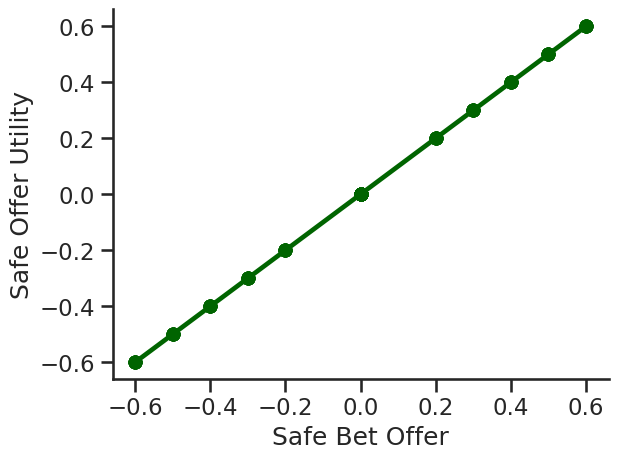

In [86]:
#safe utilities x safe offers
sns.regplot(x=a1_df.SafeBet, y=a1_df.util_safe,color = 'darkgreen',ci=None,order=2)
plt.xlabel('Safe Bet Offer')
plt.ylabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_safebet_utilsafe.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

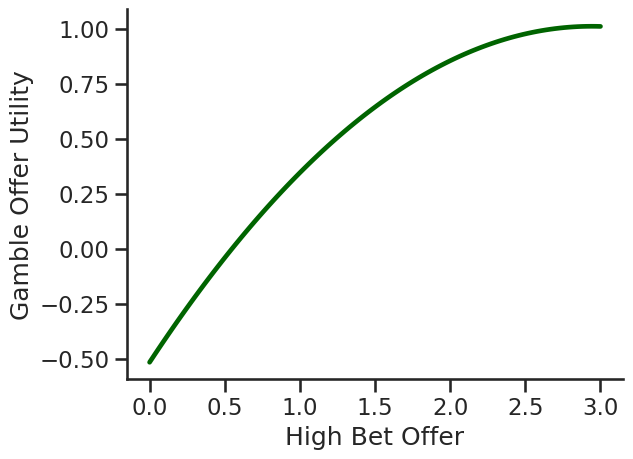

In [87]:
#gamble utilities x gamble highbet offers 

sns.regplot(x=a1_df.HighBet, y=a1_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('High Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_highbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

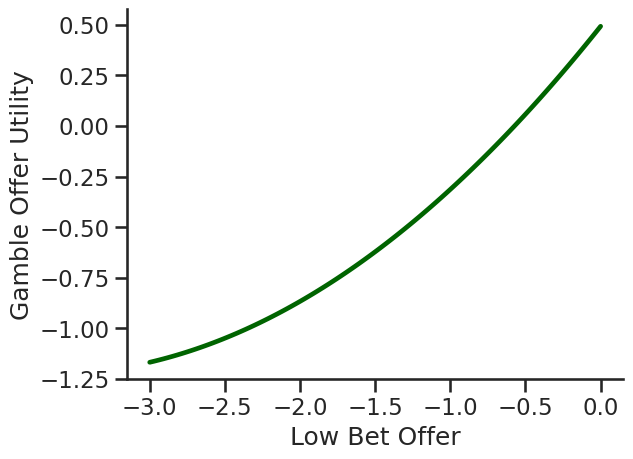

In [88]:
#gamble utilities x gamble lowbet offers 

sns.regplot(x=a1_df.LowBet, y=a1_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Low Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_lowbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

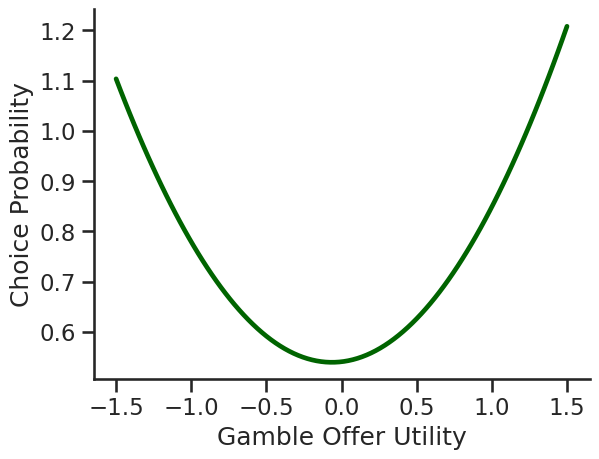

In [89]:
#gamble utility x choice prob 

sns.regplot(x=a1_df.util_gamble,y=a1_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_ChoiceProb_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


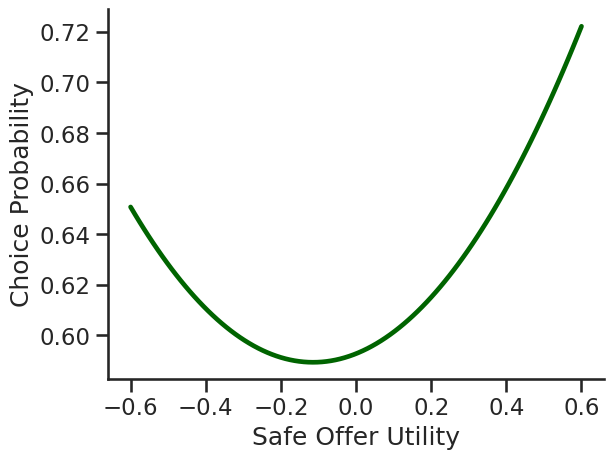

In [90]:
#safe utility x choice prob 

sns.regplot(x=a1_df.util_safe, y=a1_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_utilsafe_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

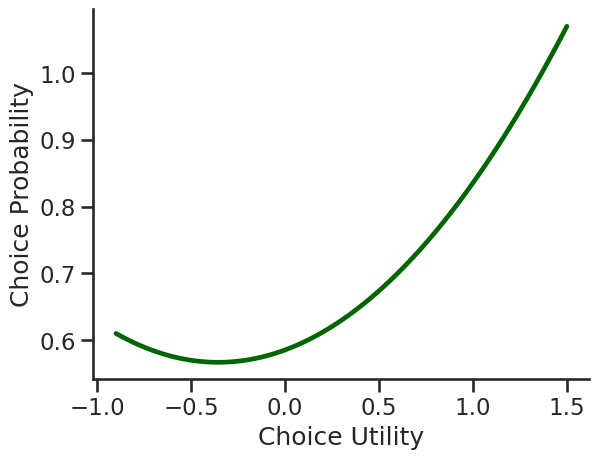

In [91]:
#choice utilities x choice probability 

sns.regplot(x=a1_df.ChoiceUtil, y=a1_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Choice Utility')
plt.ylabel('Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_ChoiceUtil_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

### Model-Free Expected Value Figs

In [32]:
#plot gamble behavior for loss, mix, gain 
a1_loss,a1_mix,a1_gain = SWB_modeling_utils.simulation_norm_gamble_choices(a1_df)


In [33]:
a1_gamble_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

df={}
df['loss_x'] = a1_loss['loss_x_axis']
df['loss_y'] = a1_loss['loss_choice_props']

df['mix_x'] = a1_mix['mix_x_axis']
df['mix_y'] =  a1_mix['mix_choice_props']

df['gain_x'] = a1_gain['gain_x_axis']
df['gain_y'] = a1_gain['gain_choice_props']

a1_gamble_plot = pd.concat([a1_gamble_plot,pd.DataFrame(df)])

a1_gamble_plot = a1_gamble_plot.dropna(axis=0)

In [34]:
a1_gamble_plot

loss_x  loss_y   mix_x     mix_y    gain_x  gain_y
0 -2.180000     0.1 -0.4285  0.200000  0.908333     0.2
1 -1.665000     0.4 -0.1885  0.363636  1.085000     0.3
2 -1.328333     0.4 -0.0675  0.272727  1.328333     0.6
3 -1.085000     0.3  0.0490  0.600000  1.665000     0.9
4 -0.908333     0.3  0.4315  0.900000  2.180000     0.9

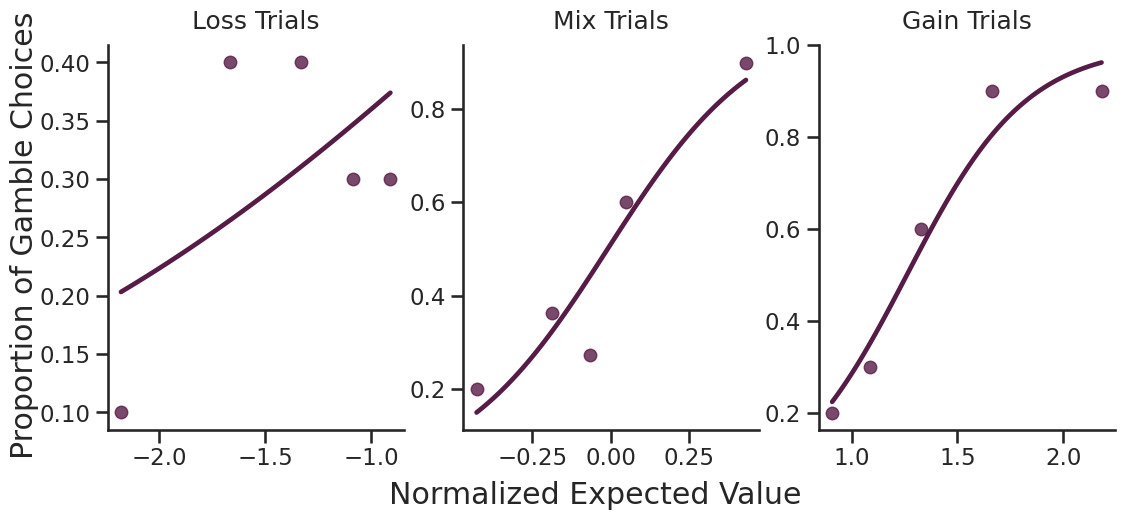

In [58]:
#Do choices make sense based on offers?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,5))

sns.regplot(ax=ax1,x=a1_gamble_plot.loss_x,y=a1_gamble_plot.loss_y,ci=None,logistic=True,color="#561C46")
# sns.regplot(ax=ax1,x=a1_loss['loss_norm_evs'],y=a1_loss['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a1_gamble_plot.mix_x,y=a1_gamble_plot.mix_y,ci=None,logistic=True,scatter=True,color="#561C46")
# sns.regplot(ax=ax2,x=a1_mix['mix_norm_evs'],y=a1_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a1_gamble_plot.gain_x,y=a1_gamble_plot.gain_y,ci=None,scatter=True,logistic=True,color="#561C46")
# sns.regplot(ax=ax3,x=a1_gain['gain_norm_evs'],y=a1_gain['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_gamble_ev_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [121]:
a1_mix #need to calculate 

{'mix_norm_evs': array([ 0.125,  0.15 , -0.1  ,  0.25 , -0.32 ,  0.   , -0.28 , -0.385,
        -0.135, -0.07 ,  0.   ,  0.275, -0.44 , -0.45 ,  0.55 , -0.19 ,
         0.   , -0.265, -0.255, -0.07 , -0.045, -0.6  , -0.12 ,  0.08 ,
         0.15 , -0.025, -0.15 ,  0.05 ,  0.375,  0.   ,  0.   ,  0.03 ,
        -0.135, -0.185,  0.075,  0.11 , -0.12 , -0.525, -0.085, -0.2  ,
        -0.05 ,  0.2  , -0.36 , -0.24 ,  0.4  , -0.33 , -0.175,  0.75 ,
        -0.09 , -0.105]),
 'mix_choices': array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1]),
 'mix_x_axis': [-0.4285, -0.1885, -0.06750000000000002, 0.049, 0.4315],
 'mix_norm_range': [array([-0.6  , -0.257]),
  array([-0.257, -0.12 ]),
  array([-0.12 , -0.015]),
  array([-0.015,  0.113]),
  array([0.113, 0.75 ])],
 'mix_choice_props': [0.1, 0.45454545454545453, 0.45454545454545453, 0.7, 0.6]}

In [24]:
mix_log = 1 / (1 + np.exp(-a1_mix['mix_norm_evs'])) #sigmoid function
mix_log

array([0.53120937, 0.41095957, 0.35434369, 0.45264238, 0.549834  ,
       0.44028635, 0.45388146, 0.5274723 , 0.5       , 0.46630116,
       0.4887519 , 0.39174097, 0.53742985, 0.5       , 0.63413559,
       0.49375033, 0.37168381, 0.47502081, 0.5124974 , 0.47003595,
       0.434135  , 0.50749944, 0.51874122, 0.5       , 0.46257015,
       0.59868766, 0.51998934, 0.4875026 , 0.47377409, 0.47876279,
       0.45636131, 0.41824062, 0.40492153, 0.5       , 0.5926666 ,
       0.450166  , 0.43659321, 0.48250714, 0.47751518, 0.43045378,
       0.6791787 , 0.53742985, 0.46630116, 0.5       , 0.5621765 ,
       0.48250714, 0.47003595, 0.38936077, 0.56831998, 0.42067575])

In [25]:
mix_invlog = -np.log((1/mix_log)-1) #inverse sigmoid (logit) function
mix_invlog

array([ 0.125, -0.36 , -0.6  , -0.19 ,  0.2  , -0.24 , -0.185,  0.11 ,
       -0.   , -0.135, -0.045, -0.44 ,  0.15 , -0.   ,  0.55 , -0.025,
       -0.525, -0.1  ,  0.05 , -0.12 , -0.265,  0.03 ,  0.075, -0.   ,
       -0.15 ,  0.4  ,  0.08 , -0.05 , -0.105, -0.085, -0.175, -0.33 ,
       -0.385, -0.   ,  0.375, -0.2  , -0.255, -0.07 , -0.09 , -0.28 ,
        0.75 ,  0.15 , -0.135, -0.   ,  0.25 , -0.07 , -0.12 , -0.45 ,
        0.275, -0.32 ])

In [36]:
#calculate risk indifference point from mix trials 

a1_sigmoid = sm.Logit(1 / (1 + np.exp(-a1_mix['mix_norm_evs'])), a1_mix['mix_choices']).fit()
print(a1_sigmoid.summary()) 
a1_indiff_pt_norm = a1_sigmoid.predict(0.5)
a1_indiff_pt = -np.log((1/a1_indiff_pt_norm)-1)
print(a1_indiff_pt)


Optimization terminated successfully.
         Current function value: 0.692651
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                -0.03837
Time:                        22:28:11   Log-Likelihood:                -34.633
converged:                       True   LL-Null:                       -33.353
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0646      0.408      0.158      0.874      -0.736       0.865
[0.03228614]


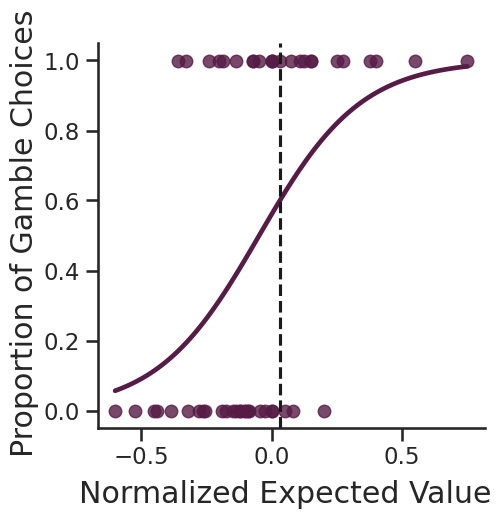

In [40]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(5,5))

sns.regplot(x=a1_mix['mix_norm_evs'],y=a1_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")

fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a1_indiff_pt, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent1/agent1_mix_ev_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### PT-Model Subjective Utility Figs

In [51]:
#plot gamble behavior for loss, mix, gain 
a1_lossU,a1_mixU,a1_gainU = SWB_modeling_utils.simulation_util_norm_gamble_choices(a1_df)



In [52]:
a1_gambleU_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])


df={}
df['loss_x'] = a1_lossU['loss_x_axis']
df['loss_y'] = a1_lossU['loss_choice_props']

df['mix_x'] = a1_mixU['mix_x_axis']
df['mix_y'] =  a1_mixU['mix_choice_props']

df['gain_x'] = a1_gainU['gain_x_axis']
df['gain_y'] = a1_gainU['gain_choice_props']

a1_gambleU_plot = pd.concat([a1_gambleU_plot,pd.DataFrame(df)])

a1_gambleU_plot = a1_gambleU_plot.dropna(axis=0)


a1_gambleU_plot

loss_x  loss_y   mix_x     mix_y    gain_x  gain_y
0 -2.180000     0.1 -0.4285  0.200000  0.908333     0.2
1 -1.665000     0.4 -0.1885  0.363636  1.085000     0.3
2 -1.328333     0.4 -0.0675  0.272727  1.328333     0.6
3 -1.085000     0.3  0.0490  0.600000  1.665000     0.9
4 -0.908333     0.3  0.4315  0.900000  2.180000     0.9

In [53]:
a1_gamble_plot

loss_x  loss_y   mix_x     mix_y    gain_x  gain_y
0 -2.180000     0.1 -0.4285  0.200000  0.908333     0.2
1 -1.665000     0.4 -0.1885  0.363636  1.085000     0.3
2 -1.328333     0.4 -0.0675  0.272727  1.328333     0.6
3 -1.085000     0.3  0.0490  0.600000  1.665000     0.9
4 -0.908333     0.3  0.4315  0.900000  2.180000     0.9

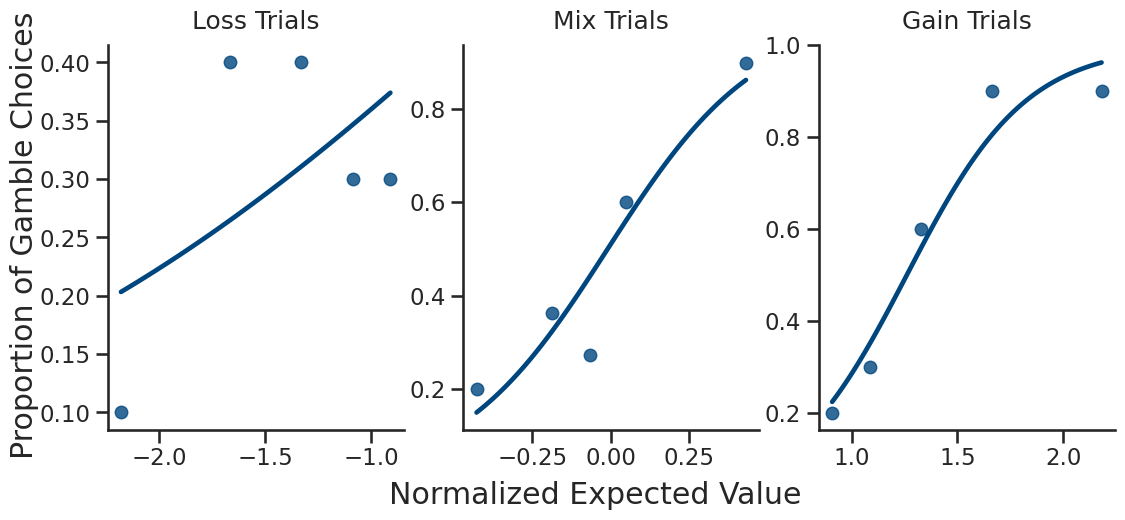

In [59]:
#Do choices make sense based on utilities?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,5))

sns.regplot(ax=ax1,x=a1_gambleU_plot.loss_x,y=a1_gambleU_plot.loss_y,ci=None,logistic=True,color="#00467e")
# sns.regplot(ax=ax1,x=a1_lossU['loss_norm_evs'],y=a1_lossU['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a1_gambleU_plot.mix_x,y=a1_gambleU_plot.mix_y,ci=None,logistic=True,scatter=True,color="#00467e")
# sns.regplot(ax=ax2,x=a1_mixU['mix_norm_evs'],y=a1_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a1_gambleU_plot.gain_x,y=a1_gambleU_plot.gain_y,ci=None,scatter=True,logistic=True,color="#00467e")
# sns.regplot(ax=ax3,x=a1_gainU['gain_norm_evs'],y=a1_gainU['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent1/agent1_gamble_Util_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [47]:
#calculate risk indifference point from mix trials 

a1_sigmoidU = sm.Logit(1 / (1 + np.exp(-a1_mixU['mix_norm_evs'])), a1_mixU['mix_choices']).fit()
print(a1_sigmoidU.summary()) 
a1_indiff_pt_normU = a1_sigmoidU.predict(0.5)
a1_indiff_ptU = -np.log((1/a1_indiff_pt_normU)-1)
print(a1_indiff_ptU)

Optimization terminated successfully.
         Current function value: 0.692651
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                -0.03837
Time:                        22:44:38   Log-Likelihood:                -34.633
converged:                       True   LL-Null:                       -33.353
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0646      0.408      0.158      0.874      -0.736       0.865
[0.03228614]


In [49]:
a1_mix['mix_norm_evs']

array([ 0.125, -0.36 , -0.6  , -0.19 ,  0.2  , -0.24 , -0.185,  0.11 ,
        0.   , -0.135, -0.045, -0.44 ,  0.15 ,  0.   ,  0.55 , -0.025,
       -0.525, -0.1  ,  0.05 , -0.12 , -0.265,  0.03 ,  0.075,  0.   ,
       -0.15 ,  0.4  ,  0.08 , -0.05 , -0.105, -0.085, -0.175, -0.33 ,
       -0.385,  0.   ,  0.375, -0.2  , -0.255, -0.07 , -0.09 , -0.28 ,
        0.75 ,  0.15 , -0.135,  0.   ,  0.25 , -0.07 , -0.12 , -0.45 ,
        0.275, -0.32 ])

In [54]:
a1_mixU['mix_norm_evs'] #this is equal when both aversion parameters are =1 (mix weighted high = high bet)

array([ 0.125, -0.36 , -0.6  , -0.19 ,  0.2  , -0.24 , -0.185,  0.11 ,
        0.   , -0.135, -0.045, -0.44 ,  0.15 ,  0.   ,  0.55 , -0.025,
       -0.525, -0.1  ,  0.05 , -0.12 , -0.265,  0.03 ,  0.075,  0.   ,
       -0.15 ,  0.4  ,  0.08 , -0.05 , -0.105, -0.085, -0.175, -0.33 ,
       -0.385,  0.   ,  0.375, -0.2  , -0.255, -0.07 , -0.09 , -0.28 ,
        0.75 ,  0.15 , -0.135,  0.   ,  0.25 , -0.07 , -0.12 , -0.45 ,
        0.275, -0.32 ])

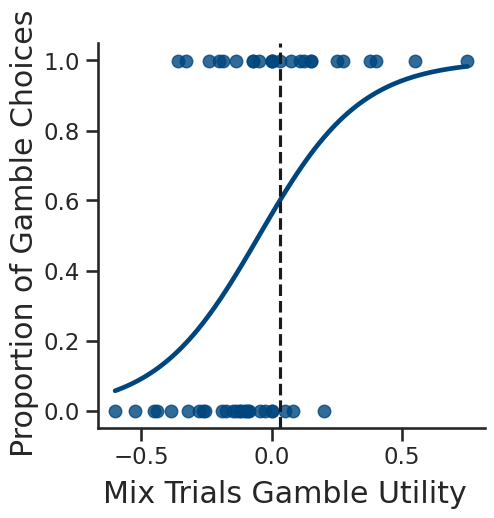

In [119]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(5,5))

sns.regplot(x=a1_mixU['mix_norm_evs'],y=a1_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#00467e")

fig.supxlabel('Mix Trials Gamble Utility',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a1_indiff_ptU, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent1/agent1_mix_Util_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### Agent 2: Risk seeking, loss tolerant 


In [93]:
a2_risk = 2
a2_loss = 0.1
a2_invtemp = 5

In [94]:
number_of_trials = 150 #single session
a2_df = SWB_modeling_utils.simulate_base_pt((a2_risk,a2_loss,a2_invtemp),number_of_trials)

In [120]:
#### create fig saving directory for agent 
os.makedirs(f'{fig_dir}agent2/',exist_ok = True) 

#save agent df in fig directory 
a2_df.to_csv(f'{fig_dir}agent2/agent2_df.csv')


### Sanity check figures 

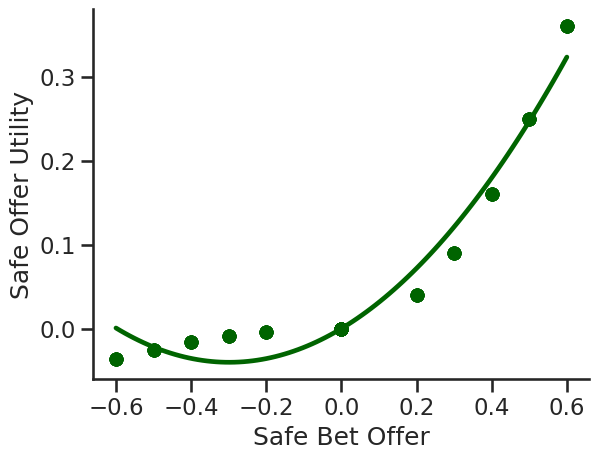

In [121]:
#safe utilities x safe offers
sns.regplot(x=a2_df.SafeBet, y=a2_df.util_safe,color = 'darkgreen',ci=None,order=2)
plt.xlabel('Safe Bet Offer')
plt.ylabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_safebet_utilsafe.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

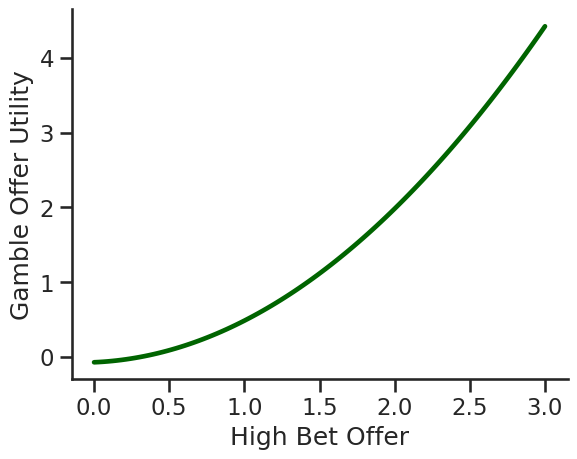

In [122]:
#gamble utilities x gamble highbet offers 

sns.regplot(x=a2_df.HighBet, y=a2_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('High Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_highbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

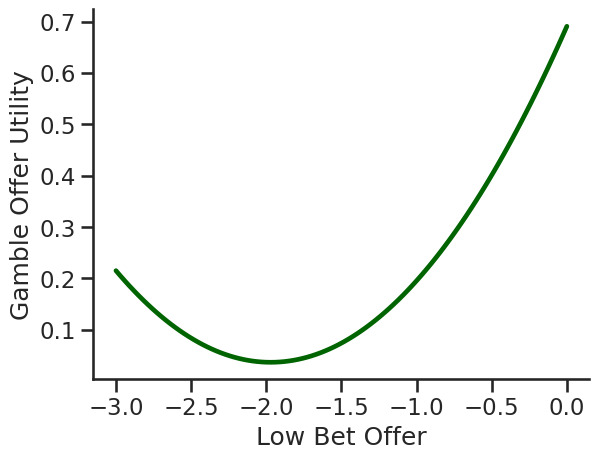

In [123]:
#gamble utilities x gamble lowbet offers 

sns.regplot(x=a2_df.LowBet, y=a2_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Low Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_lowbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

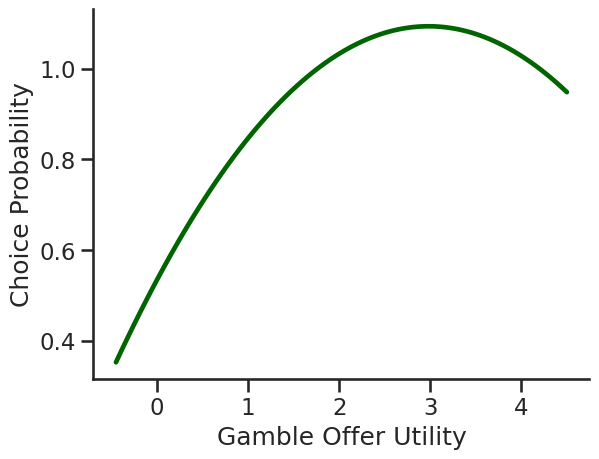

In [124]:
#gamble utility x choice prob 

sns.regplot(x=a2_df.util_gamble,y=a2_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_ChoiceProb_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


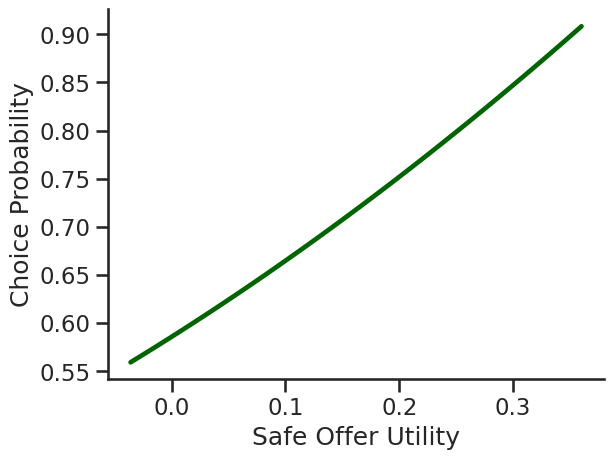

In [125]:
#safe utility x choice prob 

sns.regplot(x=a2_df.util_safe, y=a2_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_utilsafe_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

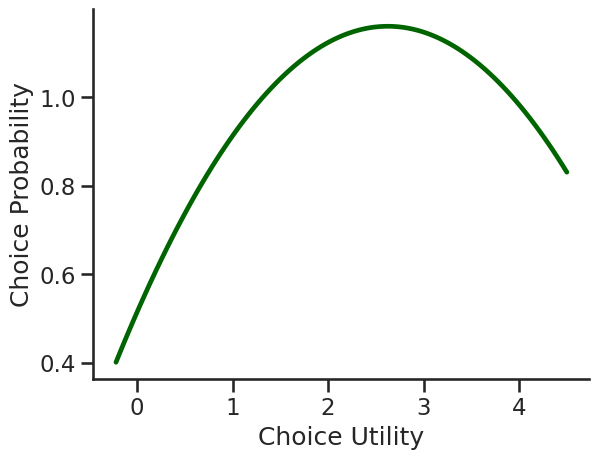

In [126]:
#choice utilities x choice probability 

sns.regplot(x=a2_df.ChoiceUtil, y=a2_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Choice Utility')
plt.ylabel('Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_ChoiceUtil_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

### Model-Free Expected Value Figs

In [128]:
#plot gamble behavior for loss, mix, gain 
a2_loss,a2_mix,a2_gain = SWB_modeling_utils.simulation_norm_gamble_choices(a2_df)


In [129]:
a2_gamble_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

df={}
df['loss_x'] = a2_loss['loss_x_axis']
df['loss_y'] = a2_loss['loss_choice_props']

df['mix_x'] = a2_mix['mix_x_axis']
df['mix_y'] =  a2_mix['mix_choice_props']

df['gain_x'] = a2_gain['gain_x_axis']
df['gain_y'] = a2_gain['gain_choice_props']

a2_gamble_plot = pd.concat([a2_gamble_plot,pd.DataFrame(df)])

a2_gamble_plot = a2_gamble_plot.dropna(axis=0)

In [130]:
a2_gamble_plot

loss_x  loss_y   mix_x     mix_y    gain_x  gain_y
0 -2.180000     0.3 -0.4285  0.400000  0.908333     0.6
1 -1.665000     0.3 -0.1885  0.636364  1.085000     0.8
2 -1.328333     0.6 -0.0675  0.545455  1.328333     0.8
3 -1.085000     0.4  0.0490  0.500000  1.665000     0.8
4 -0.908333     0.5  0.4315  0.900000  2.180000     1.0

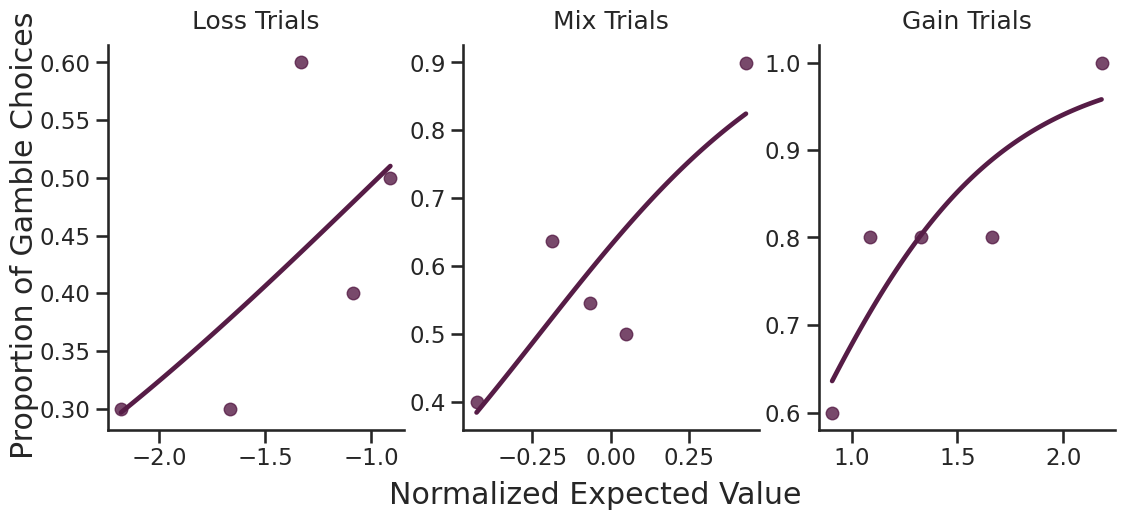

In [132]:
#Do choices make sense based on offers?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,5))

sns.regplot(ax=ax1,x=a2_gamble_plot.loss_x,y=a2_gamble_plot.loss_y,ci=None,logistic=True,color="#561C46")
# sns.regplot(ax=ax1,x=a1_loss['loss_norm_evs'],y=a1_loss['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a2_gamble_plot.mix_x,y=a2_gamble_plot.mix_y,ci=None,logistic=True,scatter=True,color="#561C46")
# sns.regplot(ax=ax2,x=a1_mix['mix_norm_evs'],y=a1_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a2_gamble_plot.gain_x,y=a2_gamble_plot.gain_y,ci=None,scatter=True,logistic=True,color="#561C46")
# sns.regplot(ax=ax3,x=a1_gain['gain_norm_evs'],y=a1_gain['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_gamble_ev_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [133]:
#calculate risk indifference point from mix trials 

a2_sigmoid = sm.Logit(1 / (1 + np.exp(-a2_mix['mix_norm_evs'])), a2_mix['mix_choices']).fit()
print(a2_sigmoid.summary()) 
a2_indiff_pt_norm = a2_sigmoid.predict(0.5)
a2_indiff_pt = -np.log((1/a2_indiff_pt_norm)-1)
print(a2_indiff_pt)


Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                -0.03910
Time:                        23:59:09   Log-Likelihood:                -34.657
converged:                       True   LL-Null:                       -33.353
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0077      0.359     -0.022      0.983      -0.712       0.696
[-0.00387035]


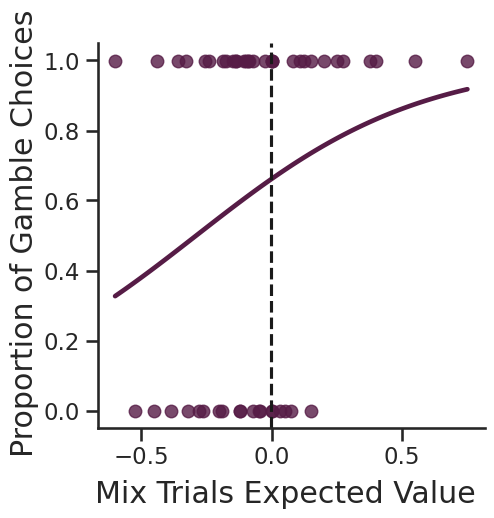

In [134]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(5,5))

sns.regplot(x=a2_mix['mix_norm_evs'],y=a2_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")

fig.supxlabel('Mix Trials Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a2_indiff_pt, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent2/agent2_mix_ev_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### PT-Model Subjective Utility Figs

In [135]:
#plot gamble behavior for loss, mix, gain 
a2_lossU,a2_mixU,a2_gainU = SWB_modeling_utils.simulation_util_norm_gamble_choices(a2_df)


In [136]:
a2_gambleU_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])


df={}
df['loss_x'] = a2_lossU['loss_x_axis']
df['loss_y'] = a2_lossU['loss_choice_props']

df['mix_x'] = a2_mixU['mix_x_axis']
df['mix_y'] =  a2_mixU['mix_choice_props']

df['gain_x'] = a2_gainU['gain_x_axis']
df['gain_y'] = a2_gainU['gain_choice_props']

a2_gambleU_plot = pd.concat([a2_gambleU_plot,pd.DataFrame(df)])

a2_gambleU_plot = a2_gambleU_plot.dropna(axis=0)


a2_gambleU_plot

loss_x  loss_y     mix_x  mix_y    gain_x  gain_y
0 -9.724000     0.3 -0.032715    0.4  1.662500     0.6
1 -5.642250     0.3  0.026285    0.7  2.379500     0.8
2 -3.579694     0.6  0.115060    0.1  3.579694     0.8
3 -2.379500     0.4  0.372005    0.9  5.642250     0.8
4 -1.662500     0.5  2.475945    1.0  9.724000     1.0

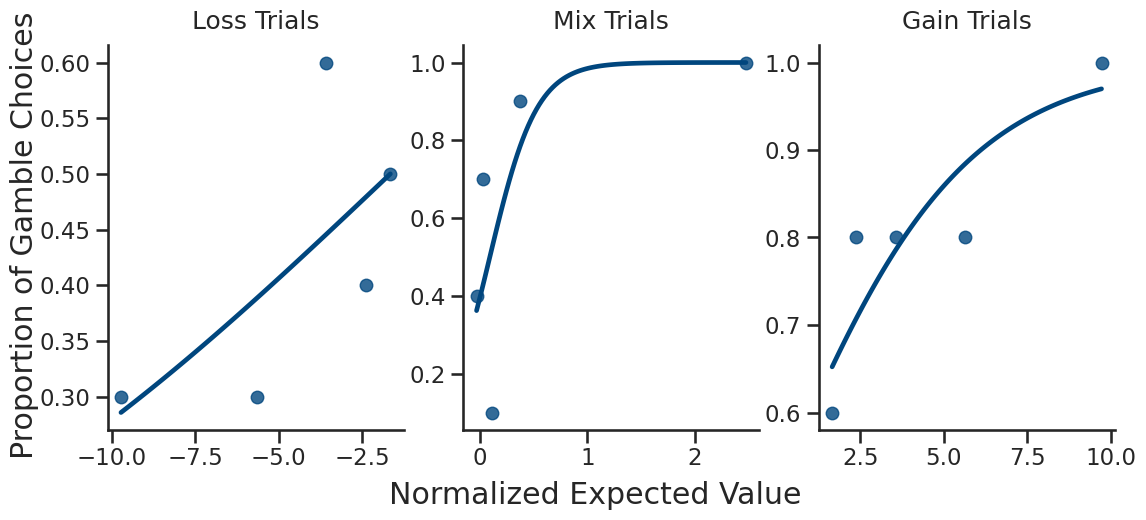

In [137]:
#Do choices make sense based on utilities?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,5))

sns.regplot(ax=ax1,x=a2_gambleU_plot.loss_x,y=a2_gambleU_plot.loss_y,ci=None,logistic=True,color="#00467e")
# sns.regplot(ax=ax1,x=a1_lossU['loss_norm_evs'],y=a1_lossU['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a2_gambleU_plot.mix_x,y=a2_gambleU_plot.mix_y,ci=None,logistic=True,scatter=True,color="#00467e")
# sns.regplot(ax=ax2,x=a1_mixU['mix_norm_evs'],y=a1_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a2_gambleU_plot.gain_x,y=a2_gambleU_plot.gain_y,ci=None,scatter=True,logistic=True,color="#00467e")
# sns.regplot(ax=ax3,x=a1_gainU['gain_norm_evs'],y=a1_gainU['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent2/agent2_gamble_Util_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [138]:
#calculate risk indifference point from mix trials 

a2_sigmoidU = sm.Logit(1 / (1 + np.exp(-a2_mixU['mix_norm_evs'])), a2_mixU['mix_choices']).fit()
print(a2_sigmoidU.summary()) 
a2_indiff_pt_normU = a2_sigmoidU.predict(0.5)
a2_indiff_ptU = -np.log((1/a2_indiff_pt_normU)-1)
print(a2_indiff_ptU)

Optimization terminated successfully.
         Current function value: 0.658537
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                  -1.194
Time:                        23:59:42   Log-Likelihood:                -32.927
converged:                       True   LL-Null:                       -15.008
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4948      0.370      1.336      0.181      -0.231       1.221
[0.24741077]


/sc/arion/work/finka03/envs/swb_behav_models/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/sc/arion/work/finka03/envs/swb_behav_models/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


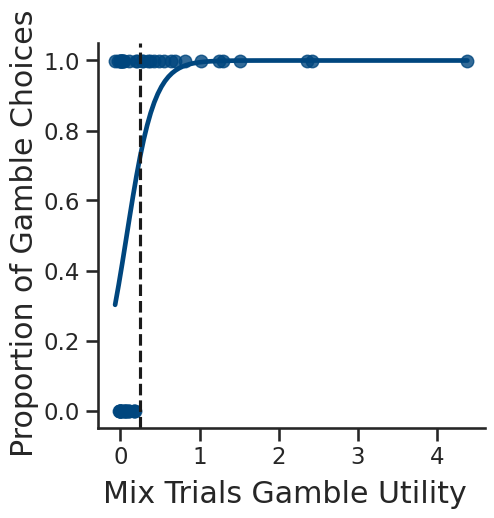

In [139]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(5,5))

sns.regplot(x=a2_mixU['mix_norm_evs'],y=a2_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#00467e")

fig.supxlabel('Mix Trials Gamble Utility',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a2_indiff_ptU, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent2/agent2_mix_Util_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### Agent 3: Risk neutral, loss averse 


In [140]:
a3_risk = 1
a3_loss = 4
a3_invtemp = 5

In [141]:
number_of_trials = 150 #single session
a3_df = SWB_modeling_utils.simulate_base_pt((a3_risk,a3_loss,a3_invtemp),number_of_trials)

In [142]:
#### create fig saving directory for agent 
os.makedirs(f'{fig_dir}agent3/',exist_ok = True) 

#save agent df in fig directory 
a3_df.to_csv(f'{fig_dir}agent3/agent3_df.csv')


### Sanity check figures 

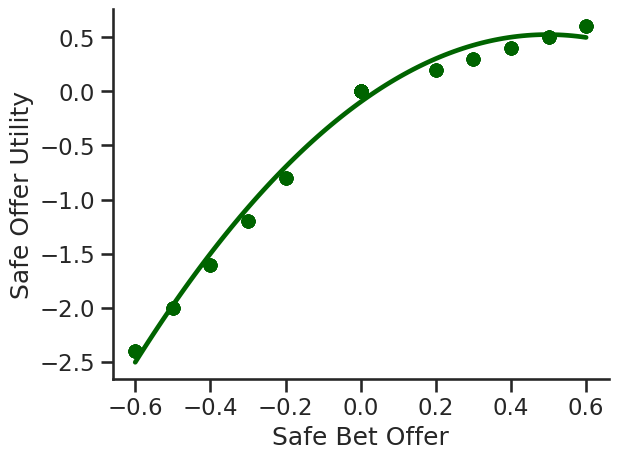

In [143]:
#safe utilities x safe offers
sns.regplot(x=a3_df.SafeBet, y=a3_df.util_safe,color = 'darkgreen',ci=None,order=2)
plt.xlabel('Safe Bet Offer')
plt.ylabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_safebet_utilsafe.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

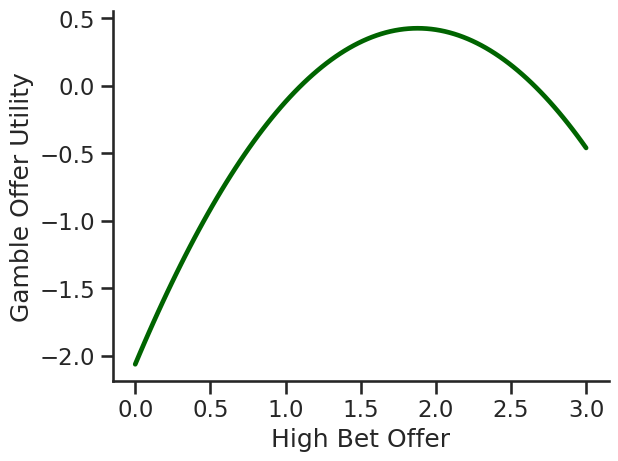

In [144]:
#gamble utilities x gamble highbet offers 

sns.regplot(x=a3_df.HighBet, y=a3_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('High Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_highbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

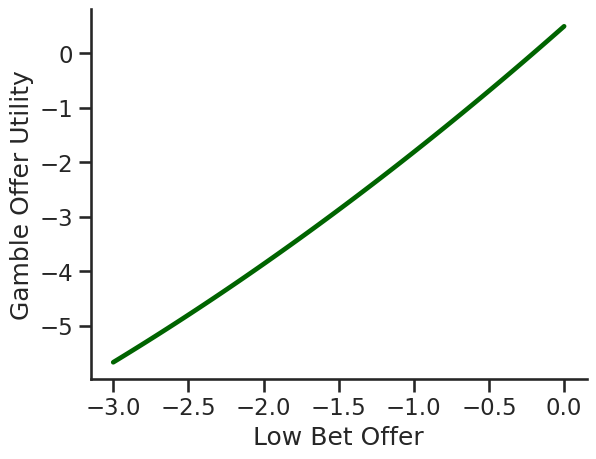

In [145]:
#gamble utilities x gamble lowbet offers 

sns.regplot(x=a3_df.LowBet, y=a3_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Low Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_lowbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

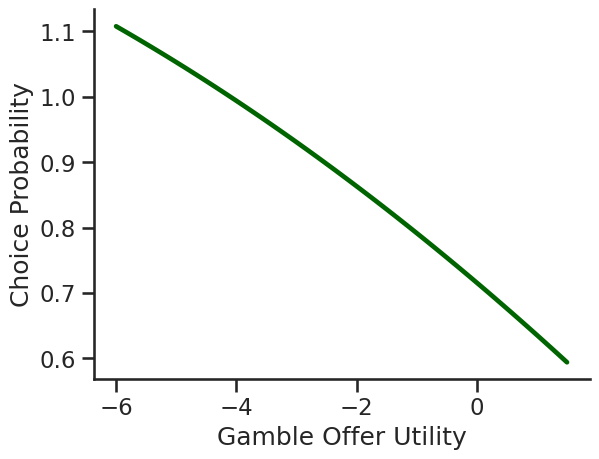

In [146]:
#gamble utility x choice prob 

sns.regplot(x=a3_df.util_gamble,y=a3_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_ChoiceProb_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


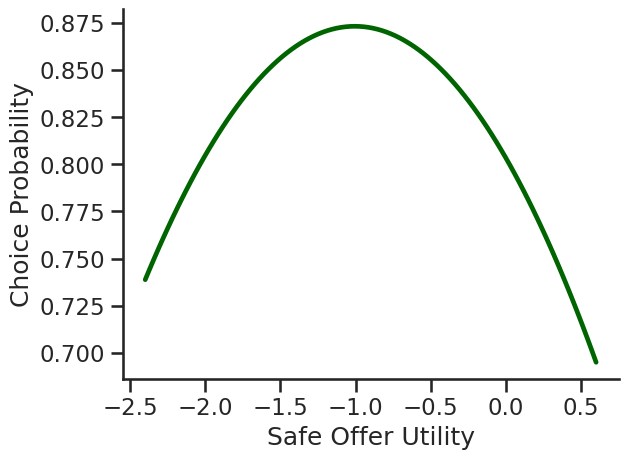

In [147]:
#safe utility x choice prob 

sns.regplot(x=a3_df.util_safe, y=a3_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_utilsafe_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

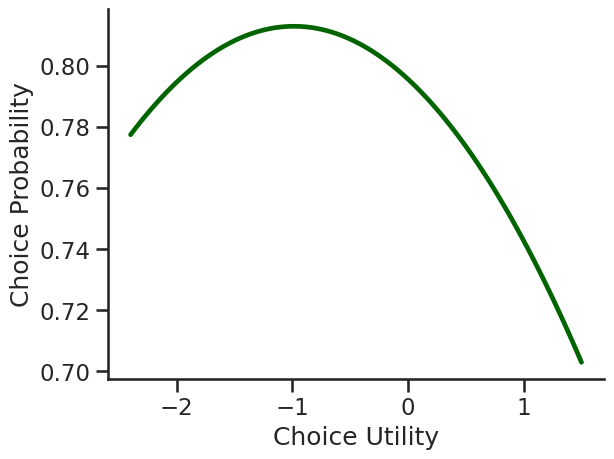

In [148]:
#choice utilities x choice probability 

sns.regplot(x=a3_df.ChoiceUtil, y=a3_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Choice Utility')
plt.ylabel('Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_ChoiceUtil_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

### Model-Free Expected Value Figs

In [149]:
#plot gamble behavior for loss, mix, gain 
a3_loss,a3_mix,a3_gain = SWB_modeling_utils.simulation_norm_gamble_choices(a3_df)


In [150]:
a3_gamble_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

df={}
df['loss_x'] = a3_loss['loss_x_axis']
df['loss_y'] = a3_loss['loss_choice_props']

df['mix_x'] = a3_mix['mix_x_axis']
df['mix_y'] =  a3_mix['mix_choice_props']

df['gain_x'] = a3_gain['gain_x_axis']
df['gain_y'] = a3_gain['gain_choice_props']

a3_gamble_plot = pd.concat([a3_gamble_plot,pd.DataFrame(df)])

a3_gamble_plot = a3_gamble_plot.dropna(axis=0)

In [151]:
a3_gamble_plot

loss_x  loss_y   mix_x  mix_y    gain_x  gain_y
0 -2.180000     0.0 -0.4285    0.0  0.908333     0.5
1 -1.665000     0.0 -0.1885    0.0  1.085000     0.5
2 -1.328333     0.1 -0.0675    0.0  1.328333     0.6
3 -1.085000     0.5  0.0490    0.1  1.665000     0.8
4 -0.908333     0.5  0.4315    0.0  2.180000     1.0

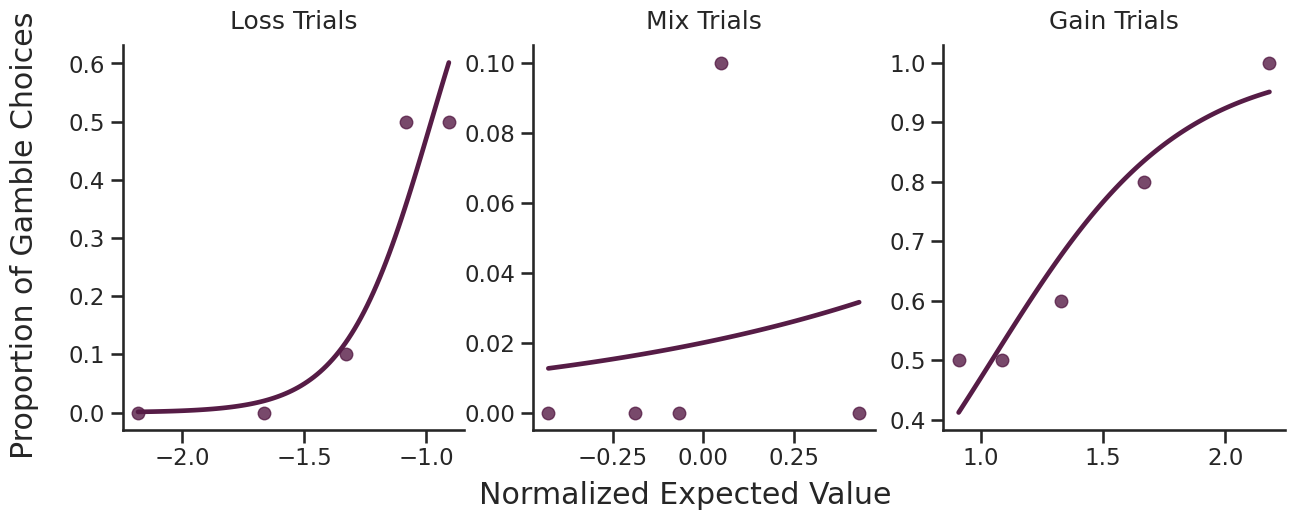

In [198]:
#Do choices make sense based on offers?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

sns.regplot(ax=ax1,x=a3_gamble_plot.loss_x,y=a3_gamble_plot.loss_y,ci=None,logistic=True,color="#561C46")
# sns.regplot(ax=ax1,x=a1_loss['loss_norm_evs'],y=a1_loss['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a3_gamble_plot.mix_x,y=a3_gamble_plot.mix_y,ci=None,logistic=True,scatter=True,color="#561C46")
# sns.regplot(ax=ax2,x=a1_mix['mix_norm_evs'],y=a1_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a3_gamble_plot.gain_x,y=a3_gamble_plot.gain_y,ci=None,scatter=True,logistic=True,color="#561C46")
# sns.regplot(ax=ax3,x=a1_gain['gain_norm_evs'],y=a1_gain['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_gamble_ev_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [153]:
#calculate risk indifference point from mix trials 

a3_sigmoid = sm.Logit(1 / (1 + np.exp(-a3_mix['mix_norm_evs'])), a3_mix['mix_choices']).fit()
print(a3_sigmoid.summary()) 
a3_indiff_pt_norm = a3_sigmoid.predict(0.5)
a3_indiff_pt = -np.log((1/a3_indiff_pt_norm)-1)
print(a3_indiff_pt)


Optimization terminated successfully.
         Current function value: 0.693119
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                -0.03907
Time:                        00:04:11   Log-Likelihood:                -34.656
converged:                       True   LL-Null:                       -33.353
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0750      2.001      0.037      0.970      -3.848       3.998

Possibly complete quasi-sepa

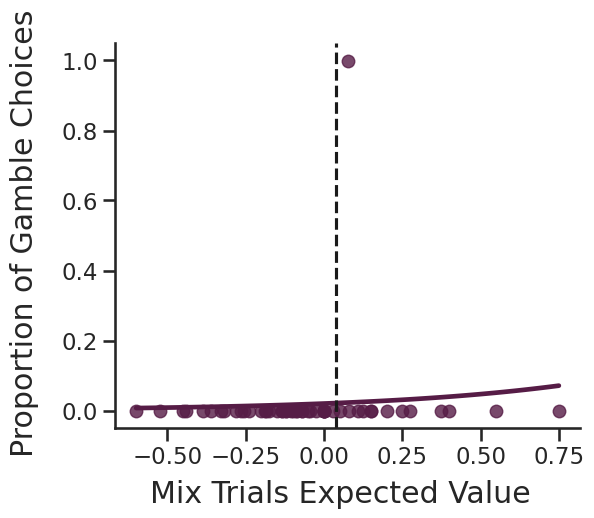

In [199]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(6,5))

sns.regplot(x=a3_mix['mix_norm_evs'],y=a3_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")

fig.supxlabel('Mix Trials Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a3_indiff_pt, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent3/agent3_mix_ev_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### PT-Model Subjective Utility Figs

In [155]:
#plot gamble behavior for loss, mix, gain 
a3_lossU,a3_mixU,a3_gainU = SWB_modeling_utils.simulation_util_norm_gamble_choices(a3_df)


In [156]:
a3_gambleU_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])


df={}
df['loss_x'] = a3_lossU['loss_x_axis']
df['loss_y'] = a3_lossU['loss_choice_props']

df['mix_x'] = a3_mixU['mix_x_axis']
df['mix_y'] =  a3_mixU['mix_choice_props']

df['gain_x'] = a3_gainU['gain_x_axis']
df['gain_y'] = a3_gainU['gain_choice_props']

a3_gambleU_plot = pd.concat([a3_gambleU_plot,pd.DataFrame(df)])

a3_gambleU_plot = a3_gambleU_plot.dropna(axis=0)


a3_gambleU_plot

loss_x  loss_y   mix_x  mix_y    gain_x  gain_y
0 -2.180000     0.0 -2.4205    0.0  0.908333     0.5
1 -1.665000     0.0 -1.7235    0.0  1.085000     0.5
2 -1.328333     0.1 -1.1980    0.0  1.328333     0.6
3 -1.085000     0.5 -0.7535    0.0  1.665000     0.8
4 -0.908333     0.5 -0.4335    0.1  2.180000     1.0

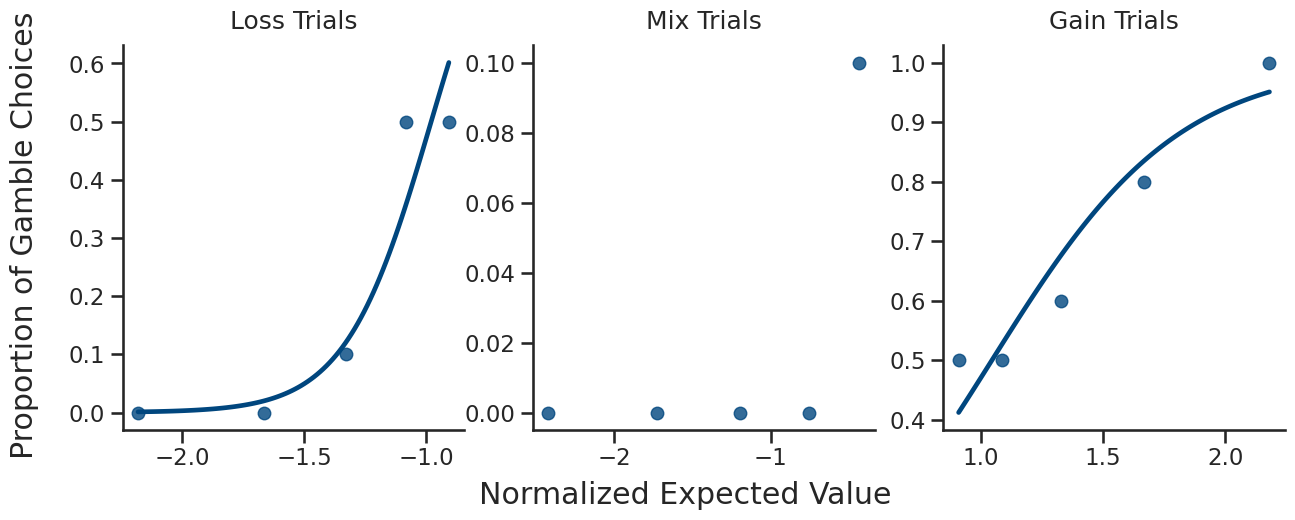

In [200]:
#Do choices make sense based on utilities?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

sns.regplot(ax=ax1,x=a3_gambleU_plot.loss_x,y=a3_gambleU_plot.loss_y,ci=None,logistic=True,color="#00467e")
# sns.regplot(ax=ax1,x=a1_lossU['loss_norm_evs'],y=a1_lossU['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a3_gambleU_plot.mix_x,y=a3_gambleU_plot.mix_y,ci=None,logistic=True,scatter=True,color="#00467e")
# sns.regplot(ax=ax2,x=a1_mixU['mix_norm_evs'],y=a1_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a3_gambleU_plot.gain_x,y=a3_gambleU_plot.gain_y,ci=None,scatter=True,logistic=True,color="#00467e")
# sns.regplot(ax=ax3,x=a1_gainU['gain_norm_evs'],y=a1_gainU['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent3/agent3_gamble_Util_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [158]:
#calculate risk indifference point from mix trials 

a3_sigmoidU = sm.Logit(1 / (1 + np.exp(-a3_mixU['mix_norm_evs'])), a3_mixU['mix_choices']).fit()
print(a3_sigmoidU.summary()) 
a3_indiff_pt_normU = a3_sigmoidU.predict(0.5)
a3_indiff_ptU = -np.log((1/a3_indiff_pt_normU)-1)
print(a3_indiff_ptU)

Optimization terminated successfully.
         Current function value: 0.692464
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                     inf
Time:                        00:06:34   Log-Likelihood:                -34.623
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3750      2.035     -0.184      0.854      -4.364       3.614
[-0.1875]


/sc/arion/work/finka03/envs/swb_behav_models/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


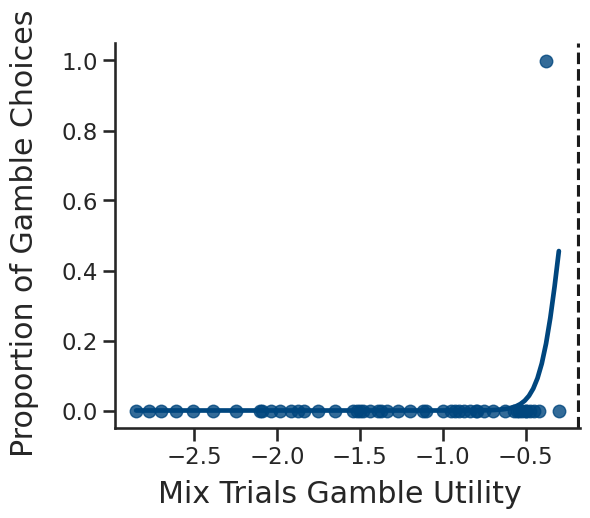

In [201]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(6,5))

sns.regplot(x=a3_mixU['mix_norm_evs'],y=a3_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#00467e")

fig.supxlabel('Mix Trials Gamble Utility',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a3_indiff_ptU, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent3/agent3_mix_Util_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### Agent 4: Risk averse, loss neutral


In [160]:
a4_risk = 0.1
a4_loss = 1
a4_invtemp = 5

In [161]:
number_of_trials = 150 #single session
a4_df = SWB_modeling_utils.simulate_base_pt((a4_risk,a4_loss,a4_invtemp),number_of_trials)

In [162]:
#### create fig saving directory for agent 
os.makedirs(f'{fig_dir}agent4/',exist_ok = True) 

#save agent df in fig directory 
a4_df.to_csv(f'{fig_dir}agent4/agent4_df.csv')


### Sanity check figures 

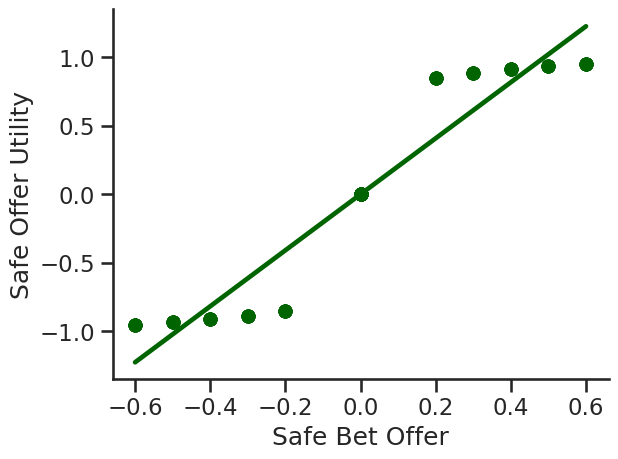

In [163]:
#safe utilities x safe offers
sns.regplot(x=a4_df.SafeBet, y=a4_df.util_safe,color = 'darkgreen',ci=None,order=2)
plt.xlabel('Safe Bet Offer')
plt.ylabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_safebet_utilsafe.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

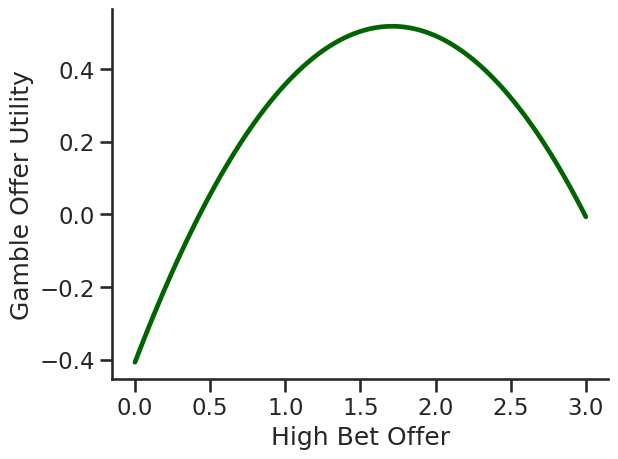

In [164]:
#gamble utilities x gamble highbet offers 

sns.regplot(x=a4_df.HighBet, y=a4_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('High Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_highbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

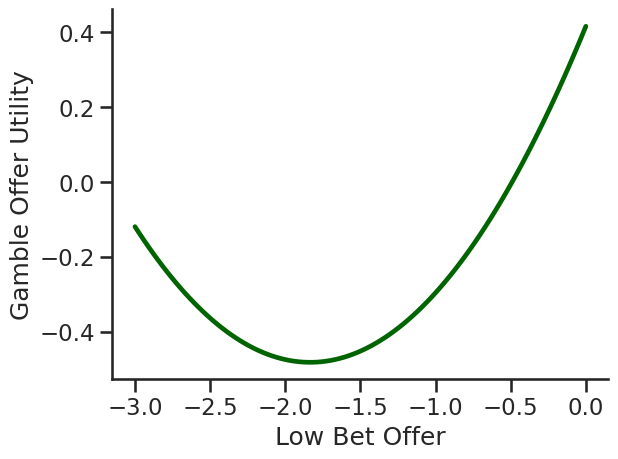

In [165]:
#gamble utilities x gamble lowbet offers 

sns.regplot(x=a4_df.LowBet, y=a4_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Low Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_lowbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

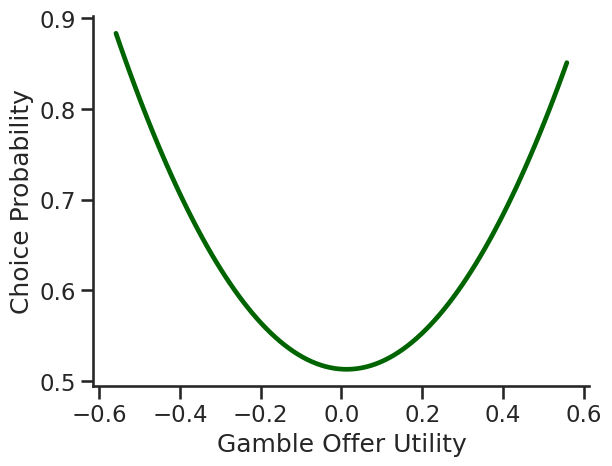

In [166]:
#gamble utility x choice prob 

sns.regplot(x=a4_df.util_gamble,y=a4_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_ChoiceProb_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


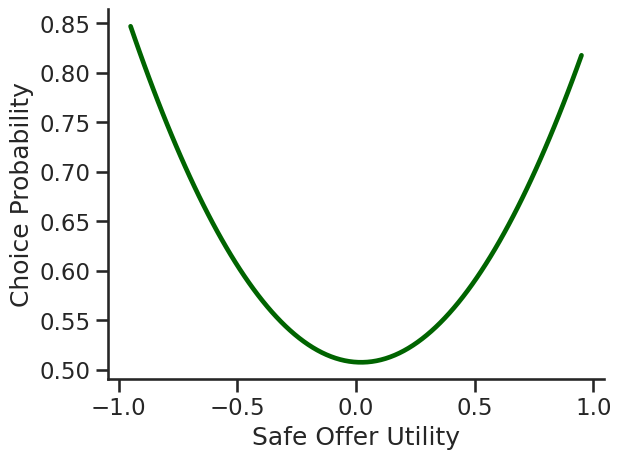

In [167]:
#safe utility x choice prob 

sns.regplot(x=a4_df.util_safe, y=a4_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_utilsafe_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

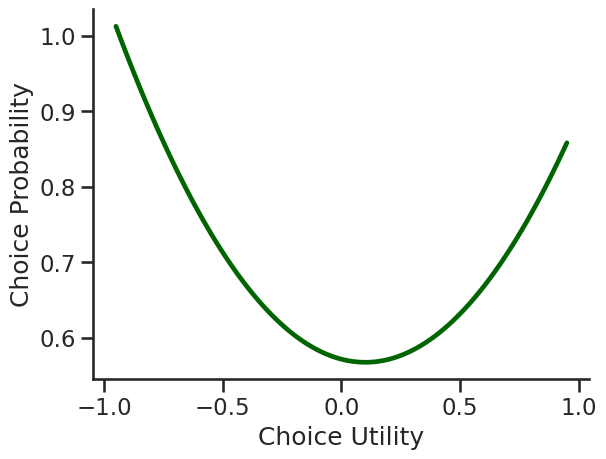

In [168]:
#choice utilities x choice probability 

sns.regplot(x=a4_df.ChoiceUtil, y=a4_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Choice Utility')
plt.ylabel('Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_ChoiceUtil_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

### Model-Free Expected Value Figs

In [169]:
#plot gamble behavior for loss, mix, gain 
a4_loss,a4_mix,a4_gain = SWB_modeling_utils.simulation_norm_gamble_choices(a4_df)


In [170]:
a4_gamble_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

df={}
df['loss_x'] = a4_loss['loss_x_axis']
df['loss_y'] = a4_loss['loss_choice_props']

df['mix_x'] = a4_mix['mix_x_axis']
df['mix_y'] =  a4_mix['mix_choice_props']

df['gain_x'] = a4_gain['gain_x_axis']
df['gain_y'] = a4_gain['gain_choice_props']

a4_gamble_plot = pd.concat([a4_gamble_plot,pd.DataFrame(df)])

a4_gamble_plot = a4_gamble_plot.dropna(axis=0)

In [171]:
a4_gamble_plot

loss_x  loss_y   mix_x     mix_y    gain_x  gain_y
0 -2.180000     0.9 -0.4285  0.400000  0.908333     0.1
1 -1.665000     1.0 -0.1885  0.454545  1.085000     0.0
2 -1.328333     0.9 -0.0675  0.636364  1.328333     0.2
3 -1.085000     0.8  0.0490  0.600000  1.665000     0.0
4 -0.908333     1.0  0.4315  0.600000  2.180000     0.3

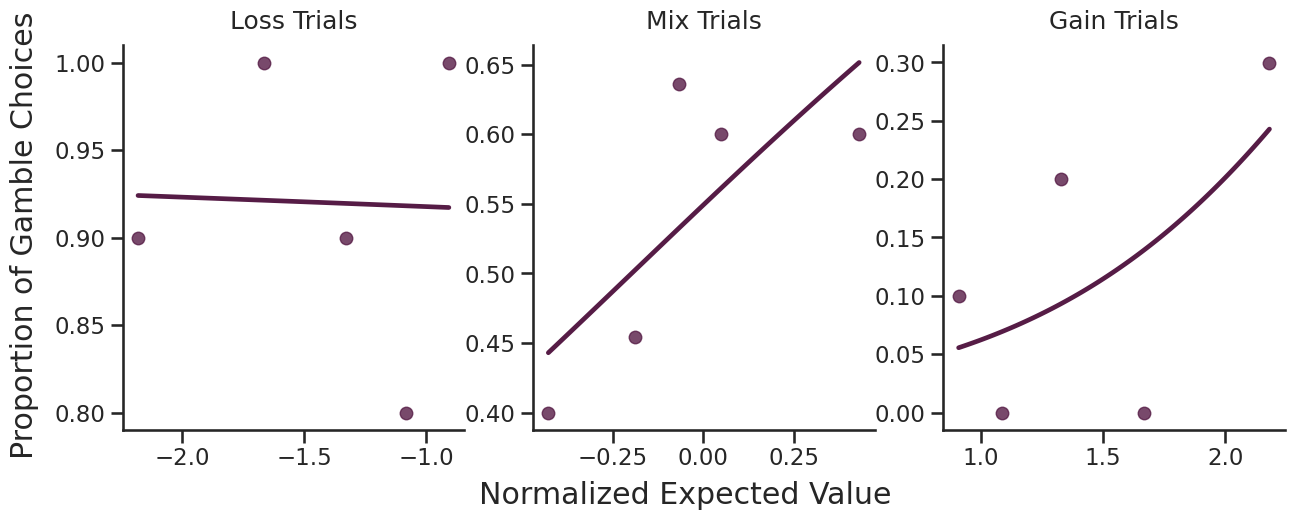

In [202]:
#Do choices make sense based on offers?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

sns.regplot(ax=ax1,x=a4_gamble_plot.loss_x,y=a4_gamble_plot.loss_y,ci=None,logistic=True,color="#561C46")
# sns.regplot(ax=ax1,x=a1_loss['loss_norm_evs'],y=a1_loss['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a4_gamble_plot.mix_x,y=a4_gamble_plot.mix_y,ci=None,logistic=True,scatter=True,color="#561C46")
# sns.regplot(ax=ax2,x=a1_mix['mix_norm_evs'],y=a1_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a4_gamble_plot.gain_x,y=a4_gamble_plot.gain_y,ci=None,scatter=True,logistic=True,color="#561C46")
# sns.regplot(ax=ax3,x=a1_gain['gain_norm_evs'],y=a1_gain['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_gamble_ev_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [175]:
#calculate risk indifference point from mix trials 

a4_sigmoid = sm.Logit(1 / (1 + np.exp(-a4_mix['mix_norm_evs'])), a4_mix['mix_choices']).fit()
print(a4_sigmoid.summary()) 
a4_indiff_pt_norm = a4_sigmoid.predict(0.5)
a4_indiff_pt = -np.log((1/a4_indiff_pt_norm)-1)
print(a4_indiff_pt)


Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                -0.03888
Time:                        00:11:29   Log-Likelihood:                -34.650
converged:                       True   LL-Null:                       -33.353
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0338      0.385     -0.088      0.930      -0.788       0.721
[-0.01691141]


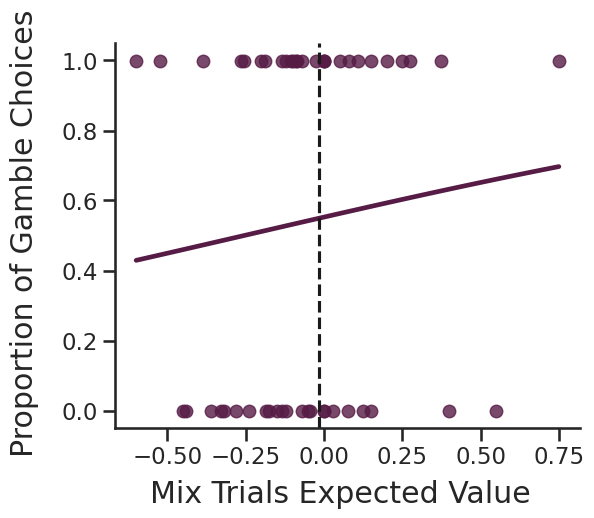

In [203]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(6,5))

sns.regplot(x=a4_mix['mix_norm_evs'],y=a4_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")

fig.supxlabel('Mix Trials Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a4_indiff_pt, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent4/agent4_mix_ev_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### PT-Model Subjective Utility Figs

In [177]:
#plot gamble behavior for loss, mix, gain 
a4_lossU,a4_mixU,a4_gainU = SWB_modeling_utils.simulation_util_norm_gamble_choices(a4_df)


In [178]:
a4_gambleU_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])


df={}
df['loss_x'] = a4_lossU['loss_x_axis']
df['loss_y'] = a4_lossU['loss_choice_props']

df['mix_x'] = a4_mixU['mix_x_axis']
df['mix_y'] =  a4_mixU['mix_choice_props']

df['gain_x'] = a4_gainU['gain_x_axis']
df['gain_y'] = a4_gainU['gain_choice_props']

a4_gambleU_plot = pd.concat([a4_gambleU_plot,pd.DataFrame(df)])

a4_gambleU_plot = a4_gambleU_plot.dropna(axis=0)


a4_gambleU_plot

loss_x  loss_y     mix_x  mix_y    gain_x  gain_y
0 -0.578702     0.9 -0.061967    0.6  0.530582     0.1
1 -0.563473     1.0 -0.035023    0.3  0.540019     0.0
2 -0.550965     0.9 -0.014162    0.6  0.550965     0.2
3 -0.540019     0.8  0.003264    0.6  0.563473     0.0
4 -0.530582     1.0  0.024352    0.6  0.578702     0.3

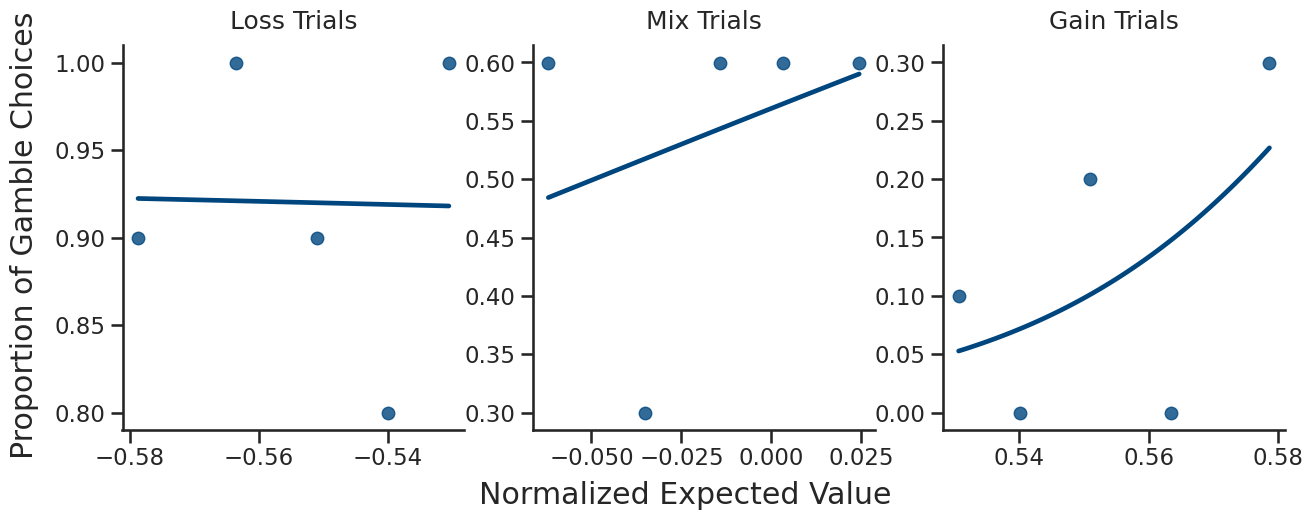

In [204]:
#Do choices make sense based on utilities?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

sns.regplot(ax=ax1,x=a4_gambleU_plot.loss_x,y=a4_gambleU_plot.loss_y,ci=None,logistic=True,color="#00467e")
# sns.regplot(ax=ax1,x=a1_lossU['loss_norm_evs'],y=a1_lossU['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a4_gambleU_plot.mix_x,y=a4_gambleU_plot.mix_y,ci=None,logistic=True,scatter=True,color="#00467e")
# sns.regplot(ax=ax2,x=a1_mixU['mix_norm_evs'],y=a1_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a4_gambleU_plot.gain_x,y=a4_gambleU_plot.gain_y,ci=None,scatter=True,logistic=True,color="#00467e")
# sns.regplot(ax=ax3,x=a1_gainU['gain_norm_evs'],y=a1_gainU['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent4/agent4_gamble_Util_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [180]:
#calculate risk indifference point from mix trials 

a4_sigmoidU = sm.Logit(1 / (1 + np.exp(-a4_mixU['mix_norm_evs'])), a4_mixU['mix_choices']).fit()
print(a4_sigmoidU.summary()) 
a4_indiff_pt_normU = a4_sigmoidU.predict(0.5)
a4_indiff_ptU = -np.log((1/a4_indiff_pt_normU)-1)
print(a4_indiff_ptU)

Optimization terminated successfully.
         Current function value: 0.693121
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                 -0.1972
Time:                        00:13:35   Log-Likelihood:                -34.656
converged:                       True   LL-Null:                       -28.947
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0139      0.385     -0.036      0.971      -0.768       0.740
[-0.00695609]


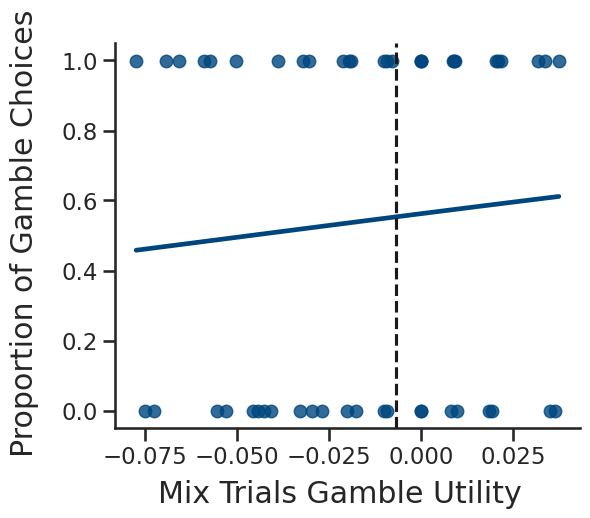

In [205]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(6,5))

sns.regplot(x=a4_mixU['mix_norm_evs'],y=a4_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#00467e")

fig.supxlabel('Mix Trials Gamble Utility',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
plt.axvline(x=a4_indiff_ptU, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent4/agent4_mix_Util_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### Agent 5: Risk averse, loss averse 

In [182]:
a5_risk = 0.1
a5_loss = 4
a5_invtemp = 5

In [183]:
number_of_trials = 150 #single session
a5_df = SWB_modeling_utils.simulate_base_pt((a5_risk,a5_loss,a5_invtemp),number_of_trials)

In [184]:
#### create fig saving directory for agent 
os.makedirs(f'{fig_dir}agent5/',exist_ok = True) 

#save agent df in fig directory 
a5_df.to_csv(f'{fig_dir}agent5/agent5_df.csv')


### Sanity check figures 

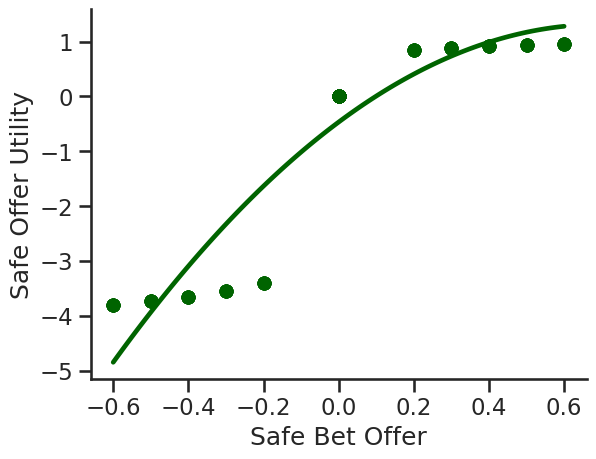

In [185]:
#safe utilities x safe offers
sns.regplot(x=a5_df.SafeBet, y=a5_df.util_safe,color = 'darkgreen',ci=None,order=2)
plt.xlabel('Safe Bet Offer')
plt.ylabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_safebet_utilsafe.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

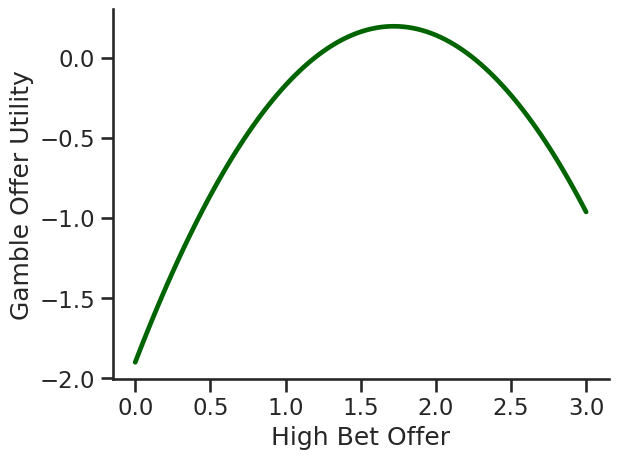

In [186]:
#gamble utilities x gamble highbet offers 

sns.regplot(x=a5_df.HighBet, y=a5_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('High Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_highbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

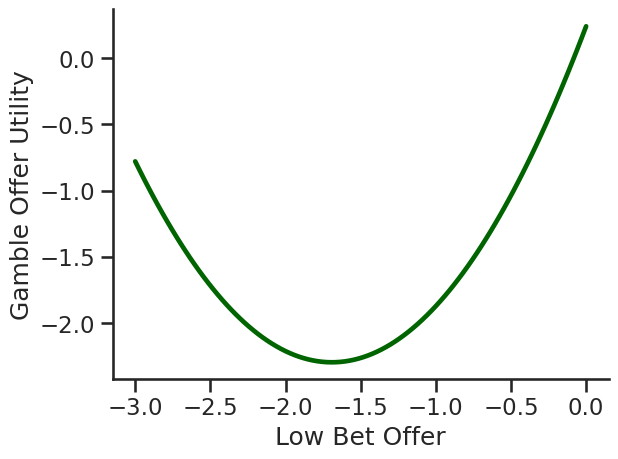

In [187]:
#gamble utilities x gamble lowbet offers 

sns.regplot(x=a5_df.LowBet, y=a5_df.util_gamble,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Low Bet Offer')
plt.ylabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_lowbet_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

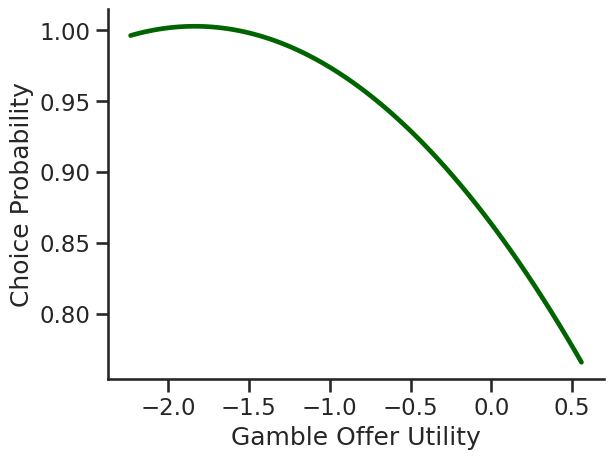

In [188]:
#gamble utility x choice prob 

sns.regplot(x=a5_df.util_gamble,y=a5_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Gamble Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_ChoiceProb_utilgamble.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


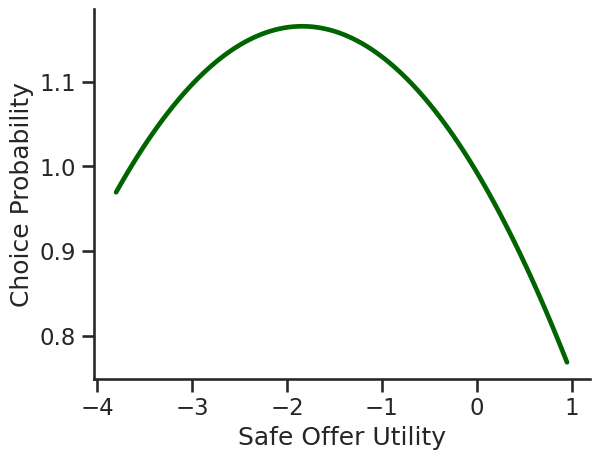

In [189]:
#safe utility x choice prob 

sns.regplot(x=a5_df.util_safe, y=a5_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.ylabel('Choice Probability')
plt.xlabel('Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_utilsafe_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

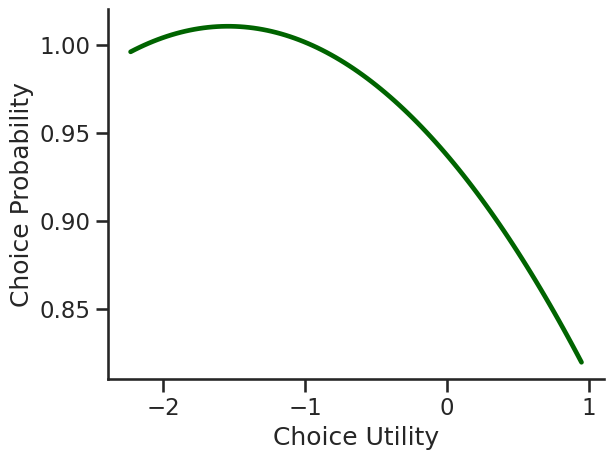

In [190]:
#choice utilities x choice probability 

sns.regplot(x=a5_df.ChoiceUtil, y=a5_df.ChoiceProb,color = 'darkgreen',ci=None,order=2,scatter=False)
plt.xlabel('Choice Utility')
plt.ylabel('Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_ChoiceUtil_ChoiceProb.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

### Model-Free Expected Value Figs

In [192]:
#plot gamble behavior for loss, mix, gain 
a5_loss,a5_mix,a5_gain = SWB_modeling_utils.simulation_norm_gamble_choices(a5_df)


In [193]:
a5_gamble_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

df={}
df['loss_x'] = a5_loss['loss_x_axis']
df['loss_y'] = a5_loss['loss_choice_props']

df['mix_x'] = a5_mix['mix_x_axis']
df['mix_y'] =  a5_mix['mix_choice_props']

df['gain_x'] = a5_gain['gain_x_axis']
df['gain_y'] = a5_gain['gain_choice_props']

a5_gamble_plot = pd.concat([a5_gamble_plot,pd.DataFrame(df)])

a5_gamble_plot = a5_gamble_plot.dropna(axis=0)

In [194]:
a5_gamble_plot

loss_x  loss_y   mix_x  mix_y    gain_x  gain_y
0 -2.180000     1.0 -0.4285    0.0  0.908333     0.2
1 -1.665000     1.0 -0.1885    0.0  1.085000     0.2
2 -1.328333     1.0 -0.0675    0.0  1.328333     0.1
3 -1.085000     1.0  0.0490    0.0  1.665000     0.1
4 -0.908333     1.0  0.4315    0.0  2.180000     0.1

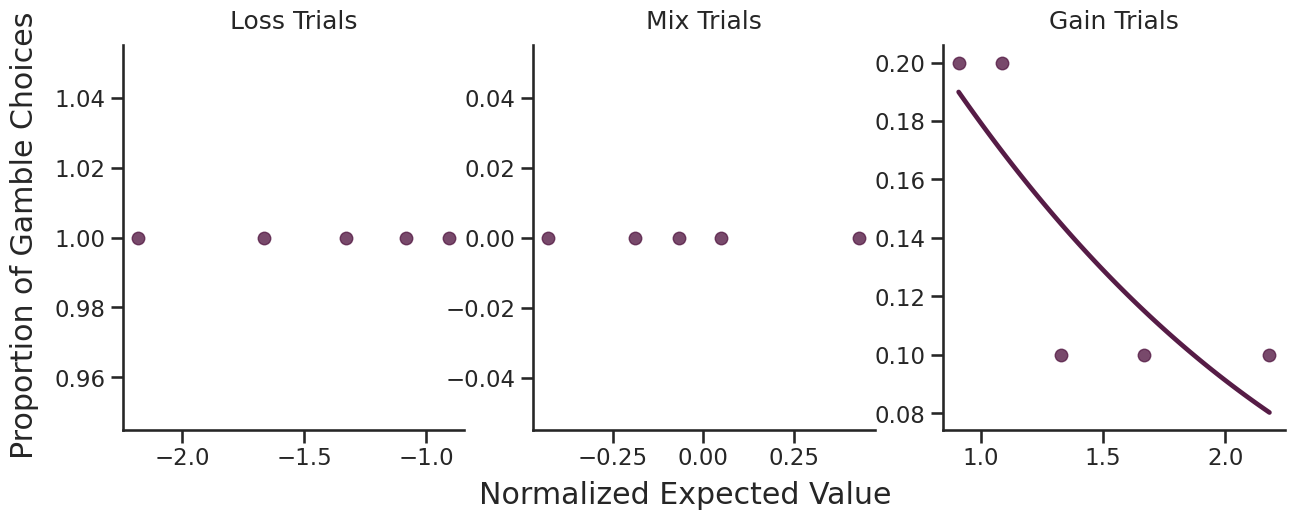

In [206]:
#Do choices make sense based on offers?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

sns.regplot(ax=ax1,x=a5_gamble_plot.loss_x,y=a5_gamble_plot.loss_y,ci=None,logistic=True,color="#561C46")
# sns.regplot(ax=ax1,x=a1_loss['loss_norm_evs'],y=a1_loss['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a5_gamble_plot.mix_x,y=a5_gamble_plot.mix_y,ci=None,logistic=True,scatter=True,color="#561C46")
# sns.regplot(ax=ax2,x=a1_mix['mix_norm_evs'],y=a1_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a5_gamble_plot.gain_x,y=a5_gamble_plot.gain_y,ci=None,scatter=True,logistic=True,color="#561C46")
# sns.regplot(ax=ax3,x=a1_gain['gain_norm_evs'],y=a1_gain['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_gamble_ev_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [ ]:
#calculate risk indifference point from mix trials 

a5_sigmoid = sm.Logit(1 / (1 + np.exp(-a5_mix['mix_norm_evs'])), a5_mix['mix_choices']).fit()
# print(a5_sigmoid.summary()) 
# a5_indiff_pt_norm = a5_sigmoid.predict(0.5)
# a5_indiff_pt = -np.log((1/a5_indiff_pt_norm)-1)
# print(a5_indiff_pt)


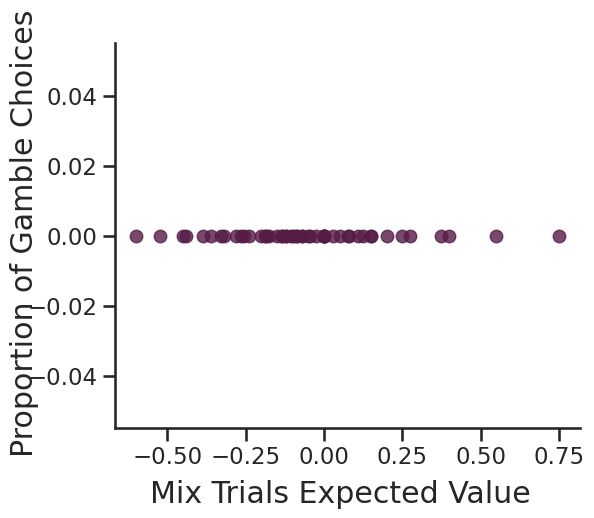

In [211]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(6,5))

sns.regplot(x=a5_mix['mix_norm_evs'],y=a5_mix['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")

fig.supxlabel('Mix Trials Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
# plt.axvline(x=a5_indiff_pt, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent5/agent5_mix_ev_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### PT-Model Subjective Utility Figs

In [215]:
#plot gamble behavior for loss, mix, gain 
a5_lossU,a5_mixU,a5_gainU = SWB_modeling_utils.simulation_util_norm_gamble_choices(a5_df)


In [216]:
a5_gambleU_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])


df={}
df['loss_x'] = a5_lossU['loss_x_axis']
df['loss_y'] = a5_lossU['loss_choice_props']

df['mix_x'] = a5_mixU['mix_x_axis']
df['mix_y'] =  a5_mixU['mix_choice_props']

df['gain_x'] = a5_gainU['gain_x_axis']
df['gain_y'] = a5_gainU['gain_choice_props']

a5_gambleU_plot = pd.concat([a5_gambleU_plot,pd.DataFrame(df)])

a5_gambleU_plot = a5_gambleU_plot.dropna(axis=0)


a5_gambleU_plot

loss_x  loss_y     mix_x  mix_y    gain_x  gain_y
0 -0.578702     1.0 -1.596590    0.0  0.530582     0.2
1 -0.563473     1.0 -1.530317    0.0  0.540019     0.2
2 -0.550965     1.0 -1.478539    0.0  0.550965     0.1
3 -0.540019     1.0 -1.415185    0.0  0.563473     0.1
4 -0.530582     1.0 -1.339130    0.0  0.578702     0.1

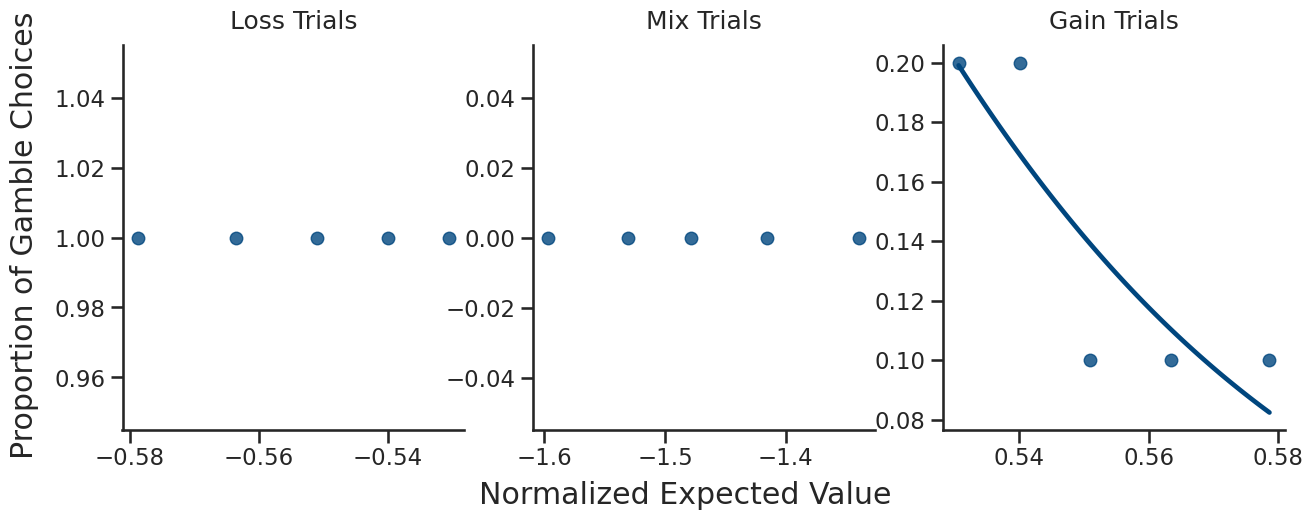

In [217]:
#Do choices make sense based on utilities?

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

sns.regplot(ax=ax1,x=a5_gambleU_plot.loss_x,y=a5_gambleU_plot.loss_y,ci=None,logistic=True,color="#00467e")
# sns.regplot(ax=ax1,x=a1_lossU['loss_norm_evs'],y=a1_lossU['loss_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax2,x=a5_gambleU_plot.mix_x,y=a5_gambleU_plot.mix_y,ci=None,logistic=True,scatter=True,color="#00467e")
# sns.regplot(ax=ax2,x=a1_mixU['mix_norm_evs'],y=a1_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#561C46")
sns.regplot(ax=ax3,x=a5_gambleU_plot.gain_x,y=a5_gambleU_plot.gain_y,ci=None,scatter=True,logistic=True,color="#00467e")
# sns.regplot(ax=ax3,x=a1_gainU['gain_norm_evs'],y=a1_gainU['gain_choices'],ci=None,logistic=True,scatter=True,color="#561C46")


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title('Loss Trials',y=1.02)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title('Mix Trials',y=1.02)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_title('Gain Trials',y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=0.05)
# fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

sns.despine()


plt.savefig(f'{fig_dir}agent5/agent5_gamble_Util_behav.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [ ]:
#calculate risk indifference point from mix trials 

# a5_sigmoidU = sm.Logit(1 / (1 + np.exp(-a5_mixU['mix_norm_evs'])), a5_mixU['mix_choices']).fit()
# print(a5_sigmoidU.summary()) 
# a5_indiff_pt_normU = a5_sigmoidU.predict(0.5)
# a5_indiff_ptU = -np.log((1/a5_indiff_pt_normU)-1)
# print(a5_indiff_ptU)

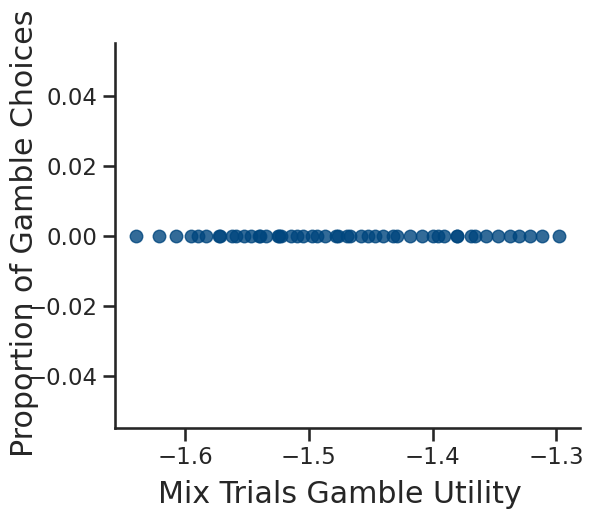

In [219]:
### calculate risk indifference point from mix trials 

fig, ax = plt.subplots(1, figsize=(6,5))

sns.regplot(x=a5_mixU['mix_norm_evs'],y=a5_mixU['mix_choices'],ci=None,logistic=True,scatter=True,color="#00467e")

fig.supxlabel('Mix Trials Gamble Utility',y=-0.05)
fig.supylabel('Proportion of Gamble Choices',x=-0.05)
# plt.axvline(x=a5_indiff_ptU, color='k',linestyle="--")
# ax.text(1.05, 0.87, "Indifference Point",fontsize=20,color = 'k') ##CDB6B6

sns.despine()

plt.savefig(f'{fig_dir}agent5/agent5_mix_Util_IP.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


# Multi-agent Simulations


In [238]:
#### data + fig directory 
os.makedirs(f'{fig_dir}grid/',exist_ok = True) 

In [228]:
#initialize 20x3 parameter grid - define full parameter ranges and make an agent for every possible combination of parameters

risk_sims = np.arange(0.1,2.1,0.1)
loss_sims = np.arange(0.3,6.3,0.3)
invtemp_sims = np.arange(0.5,10.5,0.5)


In [231]:
number_of_trials = 150 #number of trials per agent

param_grid_pt_dict = {}

for risk in risk_sims:
    for loss in loss_sims: 
        for invtemp in invtemp_sims:
            agent_params = (risk,loss,invtemp)
            agent_df = simulate_base_pt((risk,loss,invtemp),number_of_trials)
            param_grid_pt_dict[agent_params] = agent_df

param_grid_pt_dict

In [234]:
param_grid_pt_dict.keys()

dict_keys([(0.1, 0.3, 0.5), (0.1, 0.3, 1.0), (0.1, 0.3, 1.5), (0.1, 0.3, 2.0), (0.1, 0.3, 2.5), (0.1, 0.3, 3.0), (0.1, 0.3, 3.5), (0.1, 0.3, 4.0), (0.1, 0.3, 4.5), (0.1, 0.3, 5.0), (0.1, 0.3, 5.5), (0.1, 0.3, 6.0), (0.1, 0.3, 6.5), (0.1, 0.3, 7.0), (0.1, 0.3, 7.5), (0.1, 0.3, 8.0), (0.1, 0.3, 8.5), (0.1, 0.3, 9.0), (0.1, 0.3, 9.5), (0.1, 0.3, 10.0), (0.1, 0.6, 0.5), (0.1, 0.6, 1.0), (0.1, 0.6, 1.5), (0.1, 0.6, 2.0), (0.1, 0.6, 2.5), (0.1, 0.6, 3.0), (0.1, 0.6, 3.5), (0.1, 0.6, 4.0), (0.1, 0.6, 4.5), (0.1, 0.6, 5.0), (0.1, 0.6, 5.5), (0.1, 0.6, 6.0), (0.1, 0.6, 6.5), (0.1, 0.6, 7.0), (0.1, 0.6, 7.5), (0.1, 0.6, 8.0), (0.1, 0.6, 8.5), (0.1, 0.6, 9.0), (0.1, 0.6, 9.5), (0.1, 0.6, 10.0), (0.1, 0.8999999999999999, 0.5), (0.1, 0.8999999999999999, 1.0), (0.1, 0.8999999999999999, 1.5), (0.1, 0.8999999999999999, 2.0), (0.1, 0.8999999999999999, 2.5), (0.1, 0.8999999999999999, 3.0), (0.1, 0.8999999999999999, 3.5), (0.1, 0.8999999999999999, 4.0), (0.1, 0.8999999999999999, 4.5), (0.1, 0.89999999999

In [249]:
#### compute negll for each agent 

grid_negll = {}
negll_list = []

for params in param_grid_pt_dict.keys():
    df = param_grid_pt_dict[params]
    negll = -np.sum(np.log(df.ChoiceProb))
    grid_negll[params] = negll
    negll_list.append(negll)

grid_negll

{(0.1, 0.3, 0.5): 104.12365724458692,
 (0.1, 0.3, 1.0): 102.23797543620984,
 (0.1, 0.3, 1.5): 99.19690404174406,
 (0.1, 0.3, 2.0): 96.00989625277163,
 (0.1, 0.3, 2.5): 93.43291957012721,
 (0.1, 0.3, 3.0): 88.65380654824108,
 (0.1, 0.3, 3.5): 78.58995634430144,
 (0.1, 0.3, 4.0): 78.21863122309298,
 (0.1, 0.3, 4.5): 74.82283835879585,
 (0.1, 0.3, 5.0): 60.40686208413726,
 (0.1, 0.3, 5.5): 72.77004675566782,
 (0.1, 0.3, 6.0): 66.48015857560867,
 (0.1, 0.3, 6.5): 62.87925252594432,
 (0.1, 0.3, 7.0): 69.99418551019616,
 (0.1, 0.3, 7.5): 51.759108259936454,
 (0.1, 0.3, 8.0): 52.26151970457226,
 (0.1, 0.3, 8.5): 49.942486992490316,
 (0.1, 0.3, 9.0): 38.24734917743292,
 (0.1, 0.3, 9.5): 44.4326786220567,
 (0.1, 0.3, 10.0): 45.39888555733273,
 (0.1, 0.6, 0.5): 102.57982730906465,
 (0.1, 0.6, 1.0): 101.66981946514784,
 (0.1, 0.6, 1.5): 98.21370768586445,
 (0.1, 0.6, 2.0): 92.04468860875315,
 (0.1, 0.6, 2.5): 96.48241345810703,
 (0.1, 0.6, 3.0): 88.09848795933445,
 (0.1, 0.6, 3.5): 80.00307443341

In [252]:
import pickle 
date = '01112024'


# create a binary pickle file 
f = open(f'{fig_dir}grid/param_grid_pt_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(param_grid_pt_dict,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{fig_dir}grid/param_grid_negll_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(grid_negll,f)
# # close file
f.close()

In [330]:
#### calculate means for vars to compare 

grid_risks = []
grid_losses = []
grid_invtemps = []
mean_ChoiceUtil = []
mean_ChoiceProb = []
mean_UtilGamble = []
mean_UtilSafe = []
mean_GambleProb = []
mean_SafeProb = []

for params in param_grid_pt_dict.keys():
    risk_val = params[0] #get risk av value for agent
    grid_risks.append(risk_val) #add risk value for every agent to reg_list
    loss_val = params[1] #get loss av value for agent
    grid_losses.append(loss_val) #add loss value for every agent to reg_list
    invtemp_val = params[2] #get invtemp av value for agent
    grid_invtemps.append(invtemp_val) #add invtemp value for every agent to reg_list
    #load agent df 
    df = param_grid_pt_dict[params]
    avChoiceUtil = np.mean(df.ChoiceUtil)
    mean_ChoiceUtil.append(avChoiceUtil)
    avChoiceProb = np.mean(df.ChoiceProb)
    mean_ChoiceProb.append(avChoiceProb)
    avUtilGamble = np.mean(df.util_gamble)
    mean_UtilGamble.append(avUtilGamble)
    avUtilSafe = np.mean(df.util_safe)
    mean_UtilSafe.append(avUtilSafe)
    avGambleProb = np.mean(df.p_gamble)
    mean_GambleProb.append(avGambleProb)
    avSafeProb = np.mean(df.p_safe)
    mean_SafeProb.append(avSafeProb)



### Risk Distributions

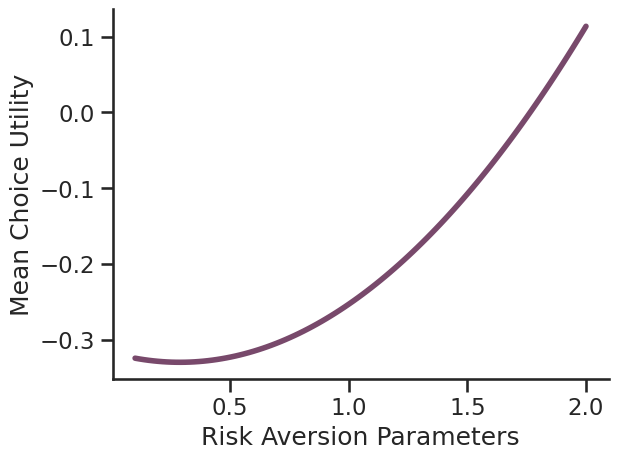

In [297]:
sns.regplot(x=grid_risks, y=mean_ChoiceUtil,color = '#78496b',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Risk Aversion Parameters')
plt.ylabel('Mean Choice Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/risks_mean_ChoiceUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

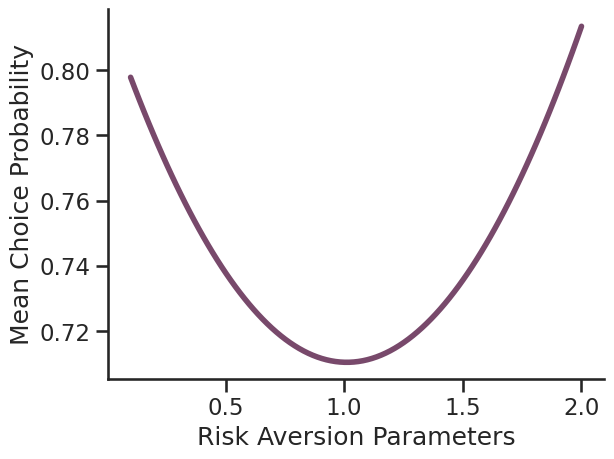

In [298]:
sns.regplot(x=grid_risks, y=mean_ChoiceProb,color = '#78496b',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Risk Aversion Parameters')
plt.ylabel('Mean Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/risks_mean_ChoiceProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

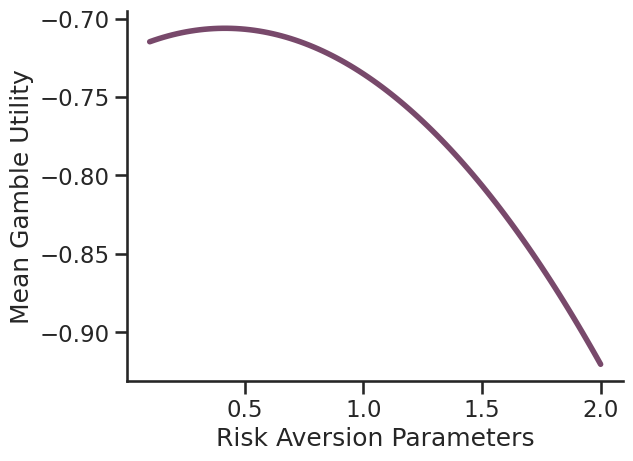

In [299]:
sns.regplot(x=grid_risks, y=mean_UtilGamble,color = '#78496b',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Risk Aversion Parameters')
plt.ylabel('Mean Gamble Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/risks_mean_GambleUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

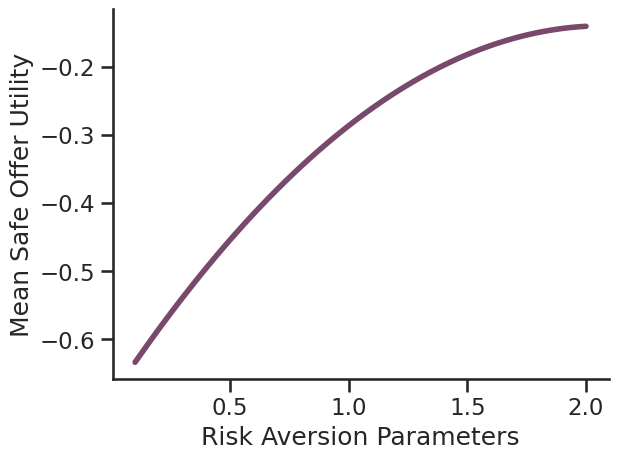

In [300]:
sns.regplot(x=grid_risks, y=mean_UtilSafe,color = '#78496b',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Risk Aversion Parameters')
plt.ylabel('Mean Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/risks_mean_SafeUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

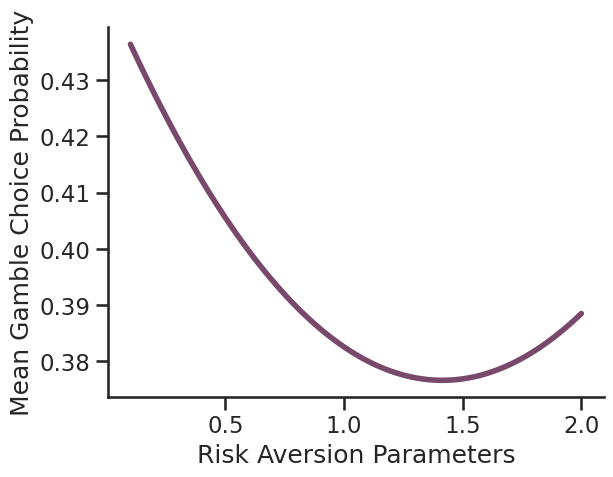

In [301]:
sns.regplot(x=grid_risks, y=mean_GambleProb,color = '#78496b',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Risk Aversion Parameters')
plt.ylabel('Mean Gamble Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/risks_mean_GambleProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

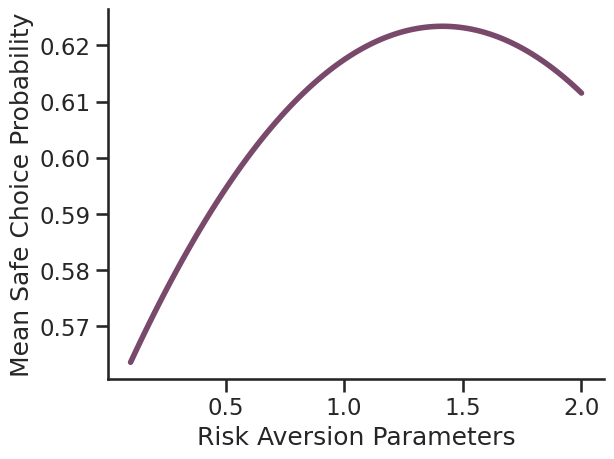

In [302]:
sns.regplot(x=grid_risks, y=mean_SafeProb,color = '#78496b',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Risk Aversion Parameters')
plt.ylabel('Mean Safe Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/risks_mean_SafeProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

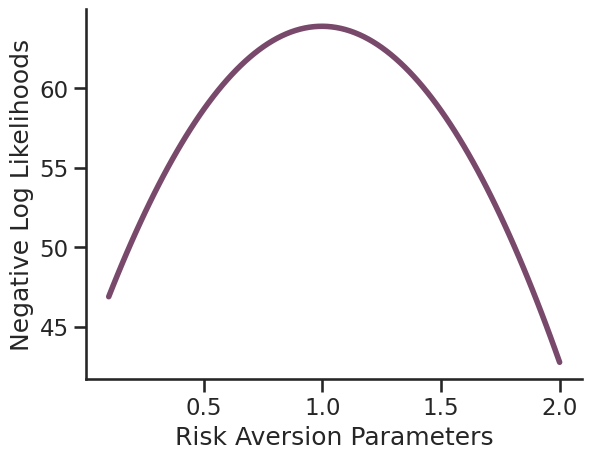

In [303]:
sns.regplot(x=grid_risks, y=negll_list,color = '#78496b',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Risk Aversion Parameters')
plt.ylabel('Negative Log Likelihoods')
sns.despine()


plt.savefig(f'{fig_dir}grid/risks_neglls.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

### Loss Distributions

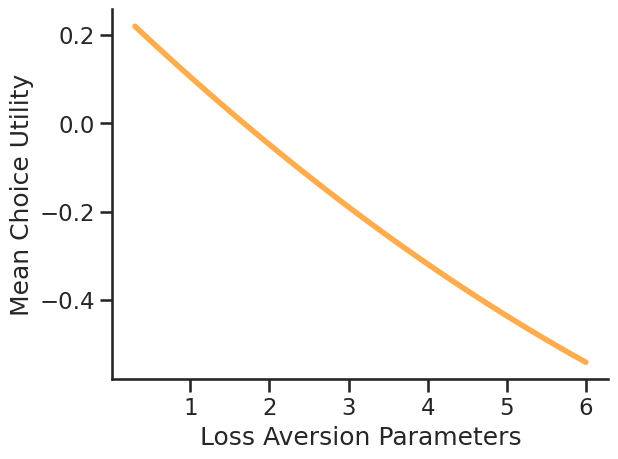

In [312]:
sns.regplot(x=grid_losses, y=mean_ChoiceUtil,color = '#ffac4d',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Loss Aversion Parameters')
plt.ylabel('Mean Choice Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/losses_mean_ChoiceUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

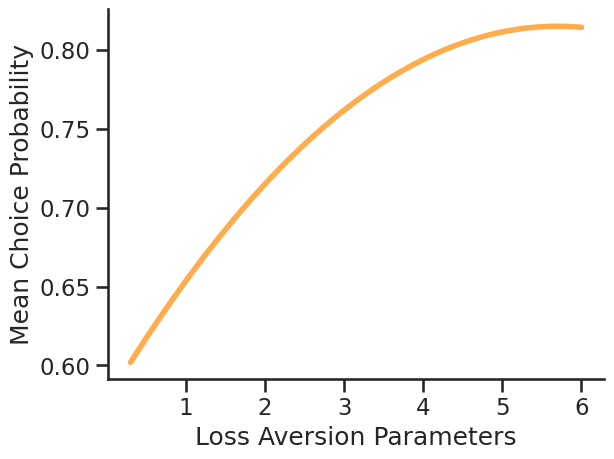

In [313]:
sns.regplot(x=grid_losses, y=mean_ChoiceProb,color = '#ffac4d',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Loss Aversion Parameters')
plt.ylabel('Mean Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/losses_mean_ChoiceProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

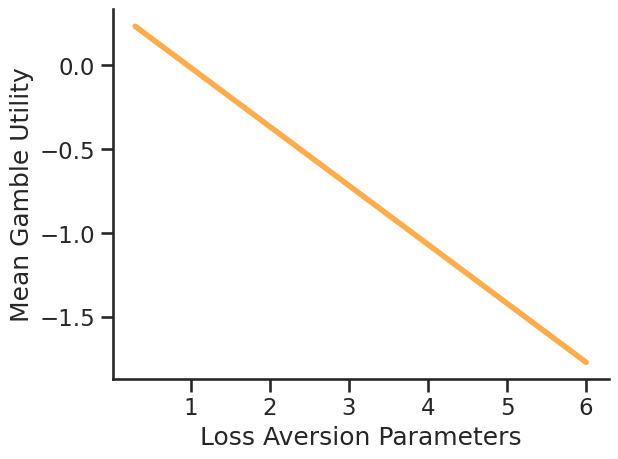

In [314]:
sns.regplot(x=grid_losses, y=mean_UtilGamble,color = '#ffac4d',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Loss Aversion Parameters')
plt.ylabel('Mean Gamble Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/losses_mean_GambleUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

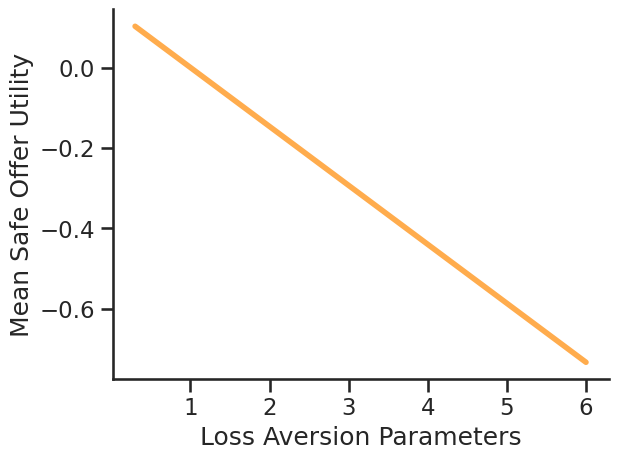

In [315]:
sns.regplot(x=grid_losses, y=mean_UtilSafe,color = '#ffac4d',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Loss Aversion Parameters')
plt.ylabel('Mean Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/losses_mean_SafeUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

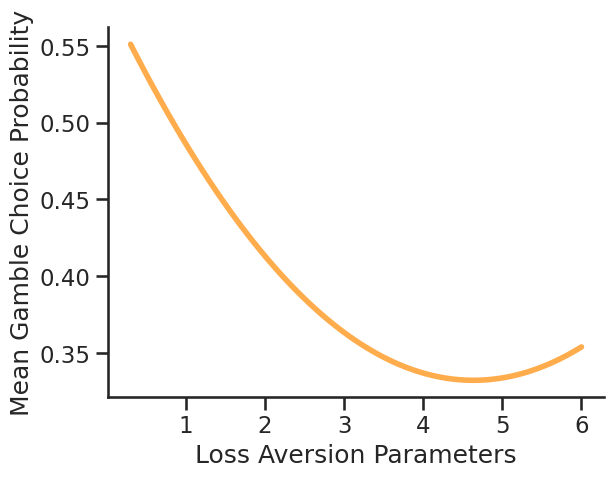

In [316]:
sns.regplot(x=grid_losses, y=mean_GambleProb,color = '#ffac4d',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Loss Aversion Parameters')
plt.ylabel('Mean Gamble Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/losses_mean_GambleProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

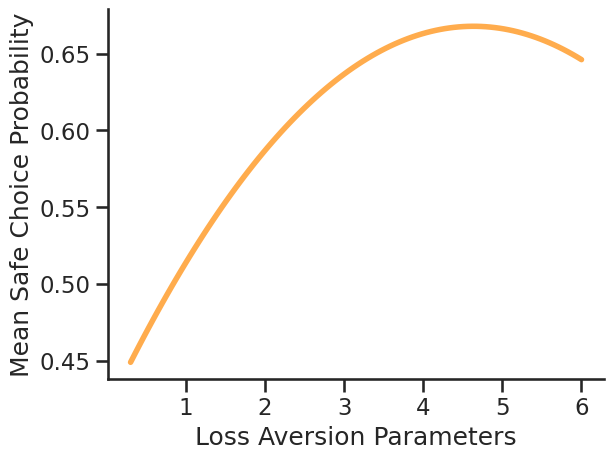

In [317]:
sns.regplot(x=grid_losses, y=mean_SafeProb,color = '#ffac4d',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Loss Aversion Parameters')
plt.ylabel('Mean Safe Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/losses_mean_SafeProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

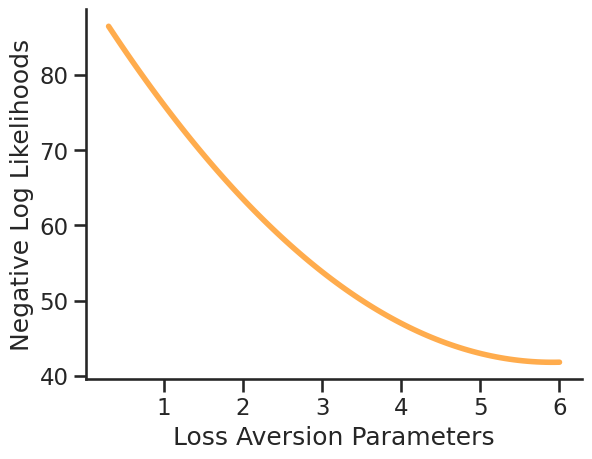

In [318]:
sns.regplot(x=grid_losses, y=negll_list,color = '#ffac4d',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Loss Aversion Parameters')
plt.ylabel('Negative Log Likelihoods')
sns.despine()


plt.savefig(f'{fig_dir}grid/losses_neglls.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

### Inverse Temp Distributions

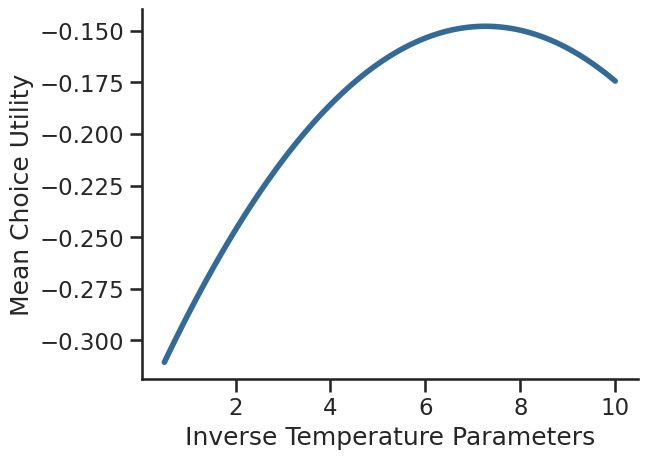

In [322]:
sns.regplot(x=grid_invtemps, y=mean_ChoiceUtil,color = '#346a97',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Inverse Temperature Parameters')
plt.ylabel('Mean Choice Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/invtemps_mean_ChoiceUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

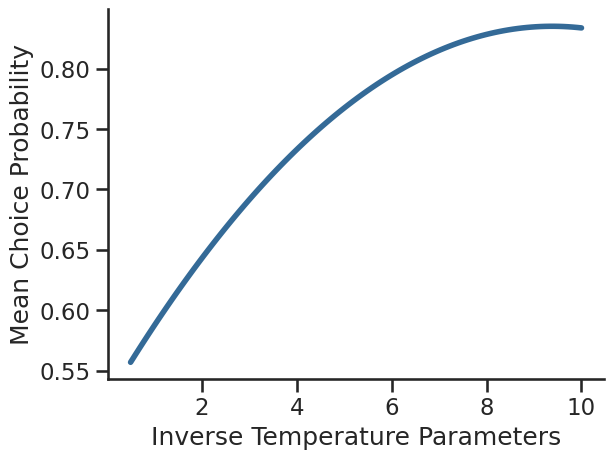

In [323]:
sns.regplot(x=grid_invtemps, y=mean_ChoiceProb,color = '#346a97',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Inverse Temperature Parameters')
plt.ylabel('Mean Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/invtemps_mean_ChoiceProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

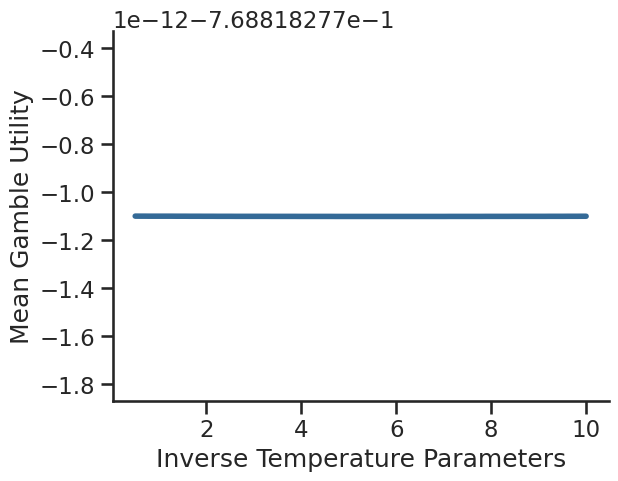

In [324]:
sns.regplot(x=grid_invtemps, y=mean_UtilGamble,color = '#346a97',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Inverse Temperature Parameters')
plt.ylabel('Mean Gamble Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/invtemps_mean_GambleUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

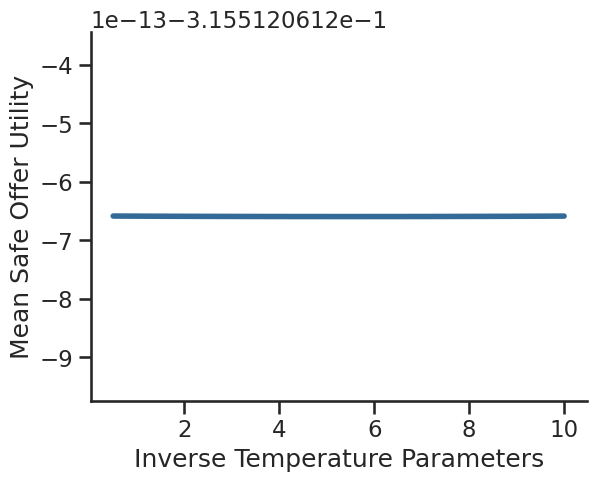

In [325]:
sns.regplot(x=grid_invtemps, y=mean_UtilSafe,color = '#346a97',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Inverse Temperature Parameters')
plt.ylabel('Mean Safe Offer Utility')
sns.despine()


plt.savefig(f'{fig_dir}grid/invtemps_mean_SafeUtils.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

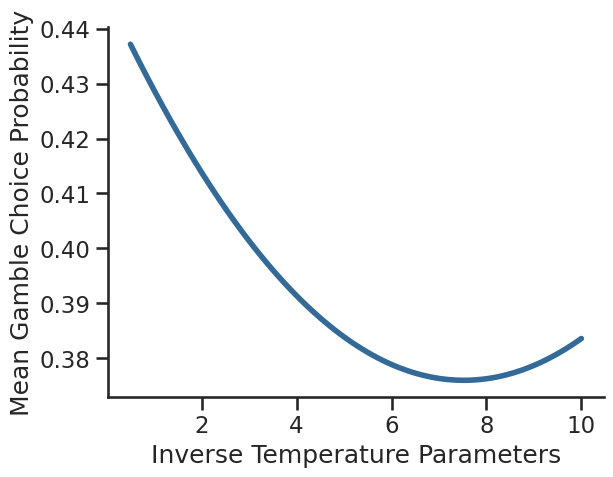

In [326]:
sns.regplot(x=grid_invtemps, y=mean_GambleProb,color = '#346a97',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Inverse Temperature Parameters')
plt.ylabel('Mean Gamble Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/invtemps_mean_GambleProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

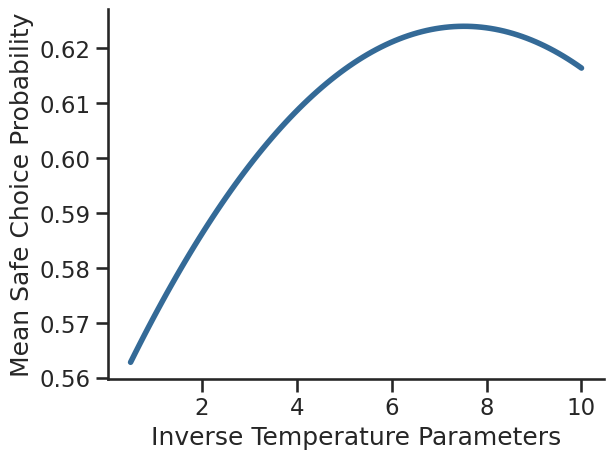

In [327]:
sns.regplot(x=grid_invtemps, y=mean_SafeProb,color = '#346a97',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Inverse Temperature Parameters')
plt.ylabel('Mean Safe Choice Probability')
sns.despine()


plt.savefig(f'{fig_dir}grid/invtemps_mean_SafeProbs.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

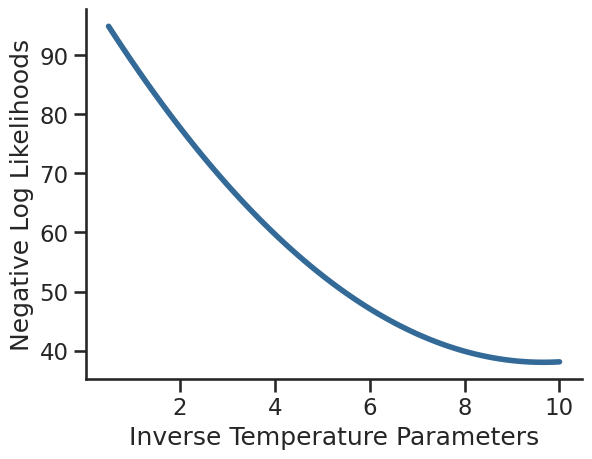

In [328]:
sns.regplot(x=grid_invtemps, y=negll_list,color = '#346a97',ci=None,order=2,scatter=False,line_kws={"linewidth": 4})
plt.xlabel('Inverse Temperature Parameters')
plt.ylabel('Negative Log Likelihoods')
sns.despine()


plt.savefig(f'{fig_dir}grid/invtemps_neglls.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

## Parameter Grid Negative Log Likelihoods

In [340]:
##### 2D heatmap - risk x loss, cmap = negll
risk_loss_grid = np.stack([risk_sims,loss_sims])
negll_risk_loss_grid = np.empty(shape = risk_loss_grid.shape)

In [ ]:
# for risk in risk_sims:
#     for loss in loss_sims: 
#         agent_params = (risk,loss,invtemp)
#         agent_df = param_grid_pt_dict[agent_params]

In [ ]:
##### 3D heatmap - risk x loss x invtemp, cmap - negll   LATER

# https://www.geeksforgeeks.org/3d-heatmap-in-python/
#https://www.educba.com/seaborn-3d-plot/ 
#https://github.com/mGalarnyk/Python_Tutorials/blob/master/Request/Heat%20Maps%20using%20Matplotlib%20and%20Seaborn.ipynb 
# https://python-graph-gallery.com/3d/
